## OCNT-DMSLIB-1 DMS Assay Run #6: TYK2 IL-23 Mini-DMS

This is the first DMS dataset derived from the IL-23 reporter system. There are 12 samples (4 replicates in each of 3 conditions), with the following structure:

| ID | Condition | Dosage | Replicates
| --- | ----------- | --- | ----------- |
| 1 | None | 0 | 4 |
| 2 | IL-23 | 100 | 4 |
| 3 | gDNA | NA | 4 |

Let's check some effects we expect to observe (mainly QC parameters and stop codons), then examine the global distribution of mutant vs WT effects across conditions.

1. [Barcode Sequencing Distributions](#part1)
2. [Inference and Stop Codon Effects](#part2)
3. [Visualizations](#part3)
4. [Raw Data Review](#part4)

In [3]:
library(magrittr)
library(data.table)
library(ggpubr)
library(vroom)
library(scales)
library(glmmTMB)
library(scico)
library(ggbeeswarm)
library(ggridges)
library(knitr)
library(fs)
library(patchwork)
library(ggnewscale)
library(tidyverse)

scale_fill_scico_mid <- function(..., mid = 0, alpha = NULL, begin = 0, end = 1, direction = 1, reverse = TRUE ,palette = "broc") {
  if (!requireNamespace("ggplot2", quietly = TRUE)) {
        stop("ggplot2 is required for this functionality", call. = FALSE)
  }
  force(mid)
  ggplot2::continuous_scale(
    aesthetics = "fill", 
    scale_name = "gradient2",
    palette = scales::gradient_n_pal(
      colours = scico(256, alpha, begin, end, direction, palette), 
      values = NULL, space = "Lab"),
    guide="colourbar",
    rescaler = function(x, to = c(0, 1), from = range(x, na.rm = TRUE)) {
      scales::rescale_mid(x, to, from, mid)
    },
    ...
  )
}

### Barcode Sequencing Distributions <a name="part1"></a>

In [3]:
mapped_counts <- vroom("../pipeline/OCNT-DMSLIB-1-assay-run6/tyk2-form.mapped-counts.tsv",
                          col_names = c("sample", "barcode", "count", "lib", "chunk",
                                        "wt_aa", "pos", "mut_aa", "wt_codon", "mut_codon", "chunkID",
                                        "dox", "condition", "condition_conc","clone")) %>%
    mutate(mut_aa = if_else(mut_aa %in% c("*", "X"), "*", mut_aa),
           condition = as.factor(paste0(condition, condition_conc)),
           mut_aa = if_else(wt_aa == mut_aa | is.na(mut_aa), "WT", mut_aa),
           mut_aa = relevel(as.factor(mut_aa), ref = "WT")) %>%
    group_by(sample) %>%
    mutate(mean_count = mean(log(count)),
           stop_count = sum(count[which(mut_aa == "*")]),
           total_count = log(sum(count)))

Rows: 2510594 Columns: 15
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (10): sample, barcode, lib, wt_aa, mut_aa, wt_codon, mut_codon, chunkID,...
dbl  (5): count, chunk, pos, dox, condition_conc

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [8]:
bc_counts_aa <- mapped_counts %>%
    filter(mut_aa != "WT") %>%
    group_by(sample,wt_aa,mut_aa,pos) %>%
    count()

bc_counts_codon <- mapped_counts %>%
    filter(mut_aa != "WT") %>%
    group_by(sample,wt_codon,mut_codon,pos) %>%
    count()

res_count <- bc_counts_aa %>%
    ggplot() +
        geom_boxplot(aes(x = sample, y = n)) +
        theme_pubr() +
        geom_hline(yintercept = 30, color = "red") +
        ylab("number of unique barcodes") + ggtitle("AA-level unique barcode counts")

codon_count <- bc_counts_codon %>%
    ggplot() +
        geom_boxplot(aes(x = sample, y = n)) +
        theme_pubr() +
        geom_hline(yintercept = 30, color = "red")  +
        ylab("number of unique barcodes") + ggtitle("Codon-level unique barcode counts")

res_count_log <- bc_counts_aa %>%
    ggplot() +
        geom_boxplot(aes(x = sample, y = log10(n))) +
        theme_pubr() +
        geom_hline(yintercept = log10(30), color = "red") +
        ylab("number of unique barcodes") + ggtitle("AA-level unique barcode counts, log10")

codon_count_log <- bc_counts_codon %>%
    ggplot() +
        geom_boxplot(aes(x = sample, y = log10(n))) +
        theme_pubr() +
        geom_hline(yintercept = log10(30), color = "red")  +
        ylab("number of unique barcodes") + ggtitle("Codon-level unique barcode counts, log10")

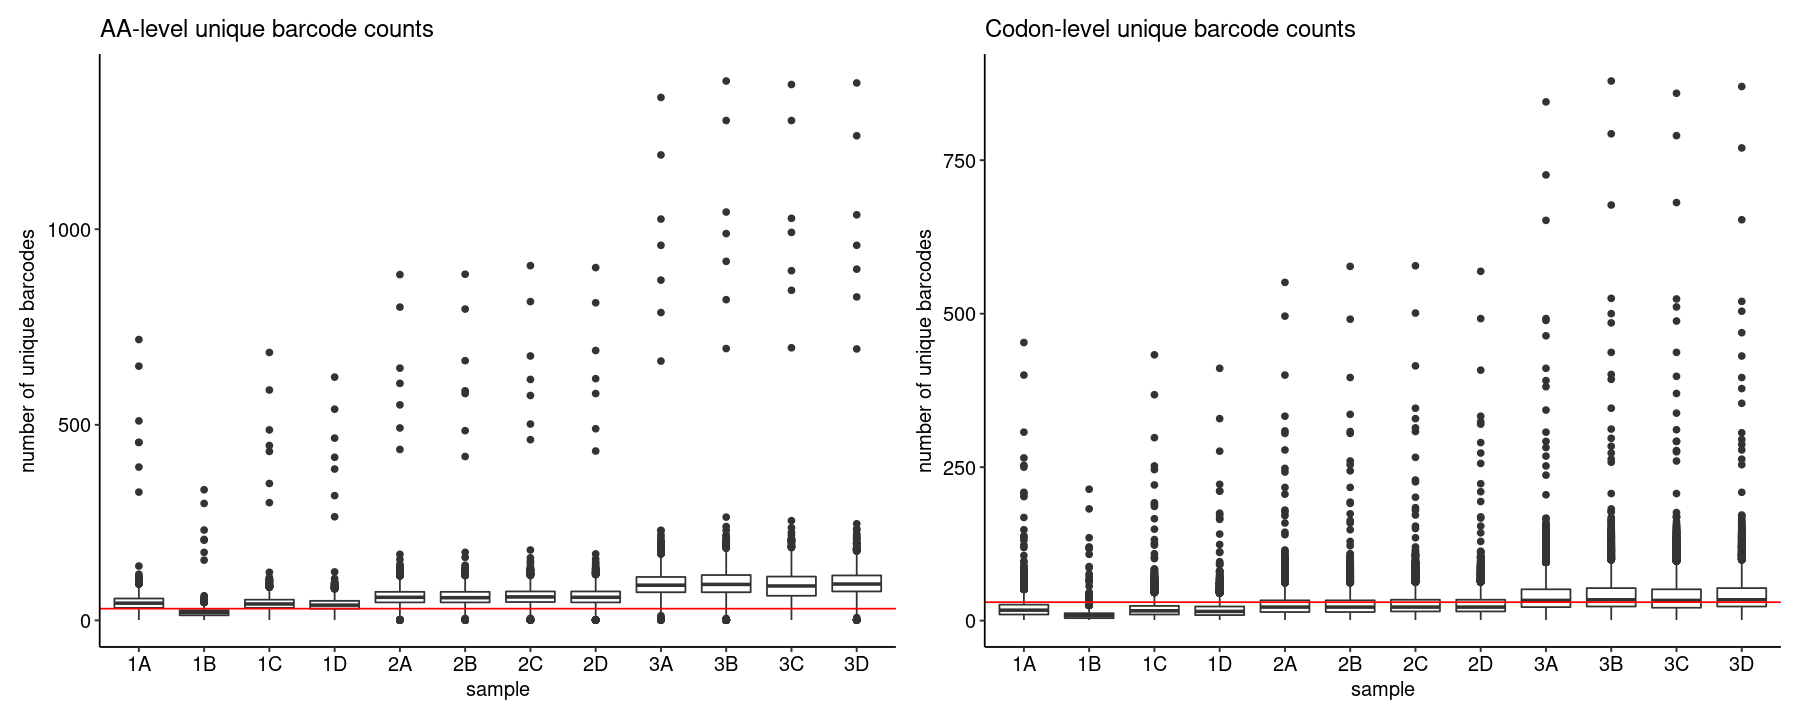

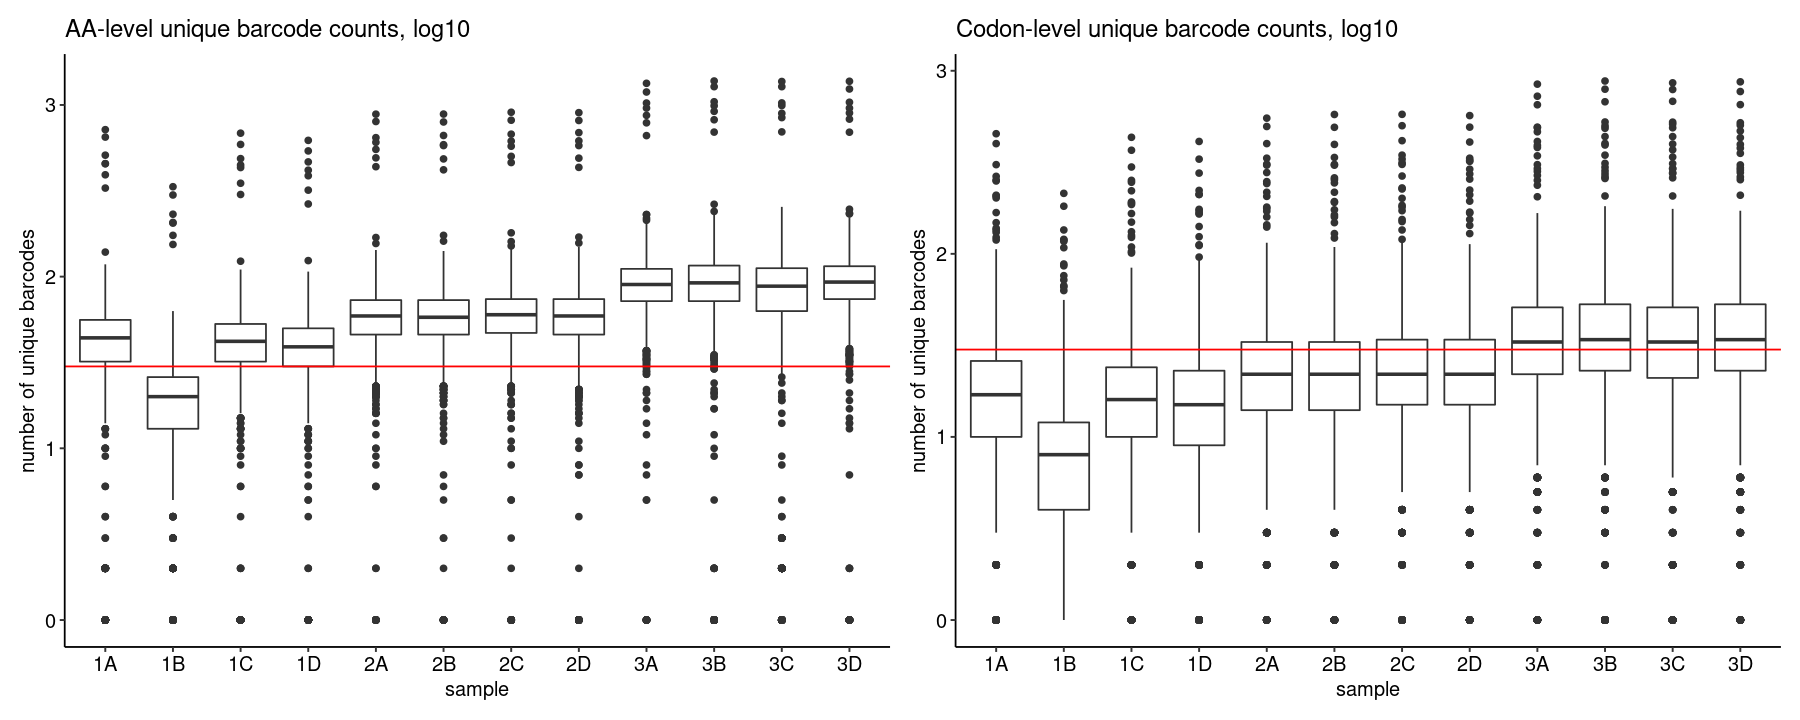

In [5]:
options(repr.plot.width = 15, repr.plot.height = 6)
res_count + codon_count
res_count_log + codon_count_log 

To get a sense of positional distribution, we can show the same data as lineplots across the length of TYK2. Below is an example using sample `1A` only; the remaining plots can be found [here](./coverage-plots):

In [11]:
plot_coverage <- function(bcs, sample_id) {
    
    wt_aa <- read_tsv("../data/tyk2/tyk2-wt-aa.tsv")
    
    bcs_subset <- bcs %>%
        filter(sample == sample_id)
    
    allpos <- expand_grid("pos" = 1:1188,
                     "mut_aa" = unique(bcs$mut_aa)) %>%
        filter(!paste0(pos, mut_aa) %in% paste0(wt_aa$pos, wt_aa$wt_aa))

    bcs_subset_expanded <- allpos %>%
        left_join(bcs_subset) %>%
        mutate(n = if_else(is.na(n), 0, n))
    
    the_plot <- ggplot(bcs_subset_expanded) +
        geom_line(aes(x = as.numeric(pos), y = log10(n))) +
        theme_bw(base_size = 16) +
        ggtitle(paste0("Sample ", sample_id)) +
        facet_wrap(~mut_aa, ncol = 1) +
        xlab("TYK2 position") + ylab("log10(number of unique barcodes)")
    
    ggsave(paste0("coverage-plots/OCNT-DMSLIB-1-assay-run6-sample", sample_id, ".pdf"),
           the_plot, width = 10, height = 20)
    
    return(the_plot)
}

In [13]:
coverage_plots <- map(.x = unique(bc_counts_aa$sample), .f = ~plot_coverage(bc_counts_aa, .))

Rows: 1189 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): wt_aa
dbl (1): pos

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Joining with `by = join_by(pos, mut_aa)`
Rows: 1189 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): wt_aa
dbl (1): pos

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Joining with `by = join_by(pos, mut_aa)`
Rows: 1189 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): wt_aa
dbl (1): pos

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Joining with

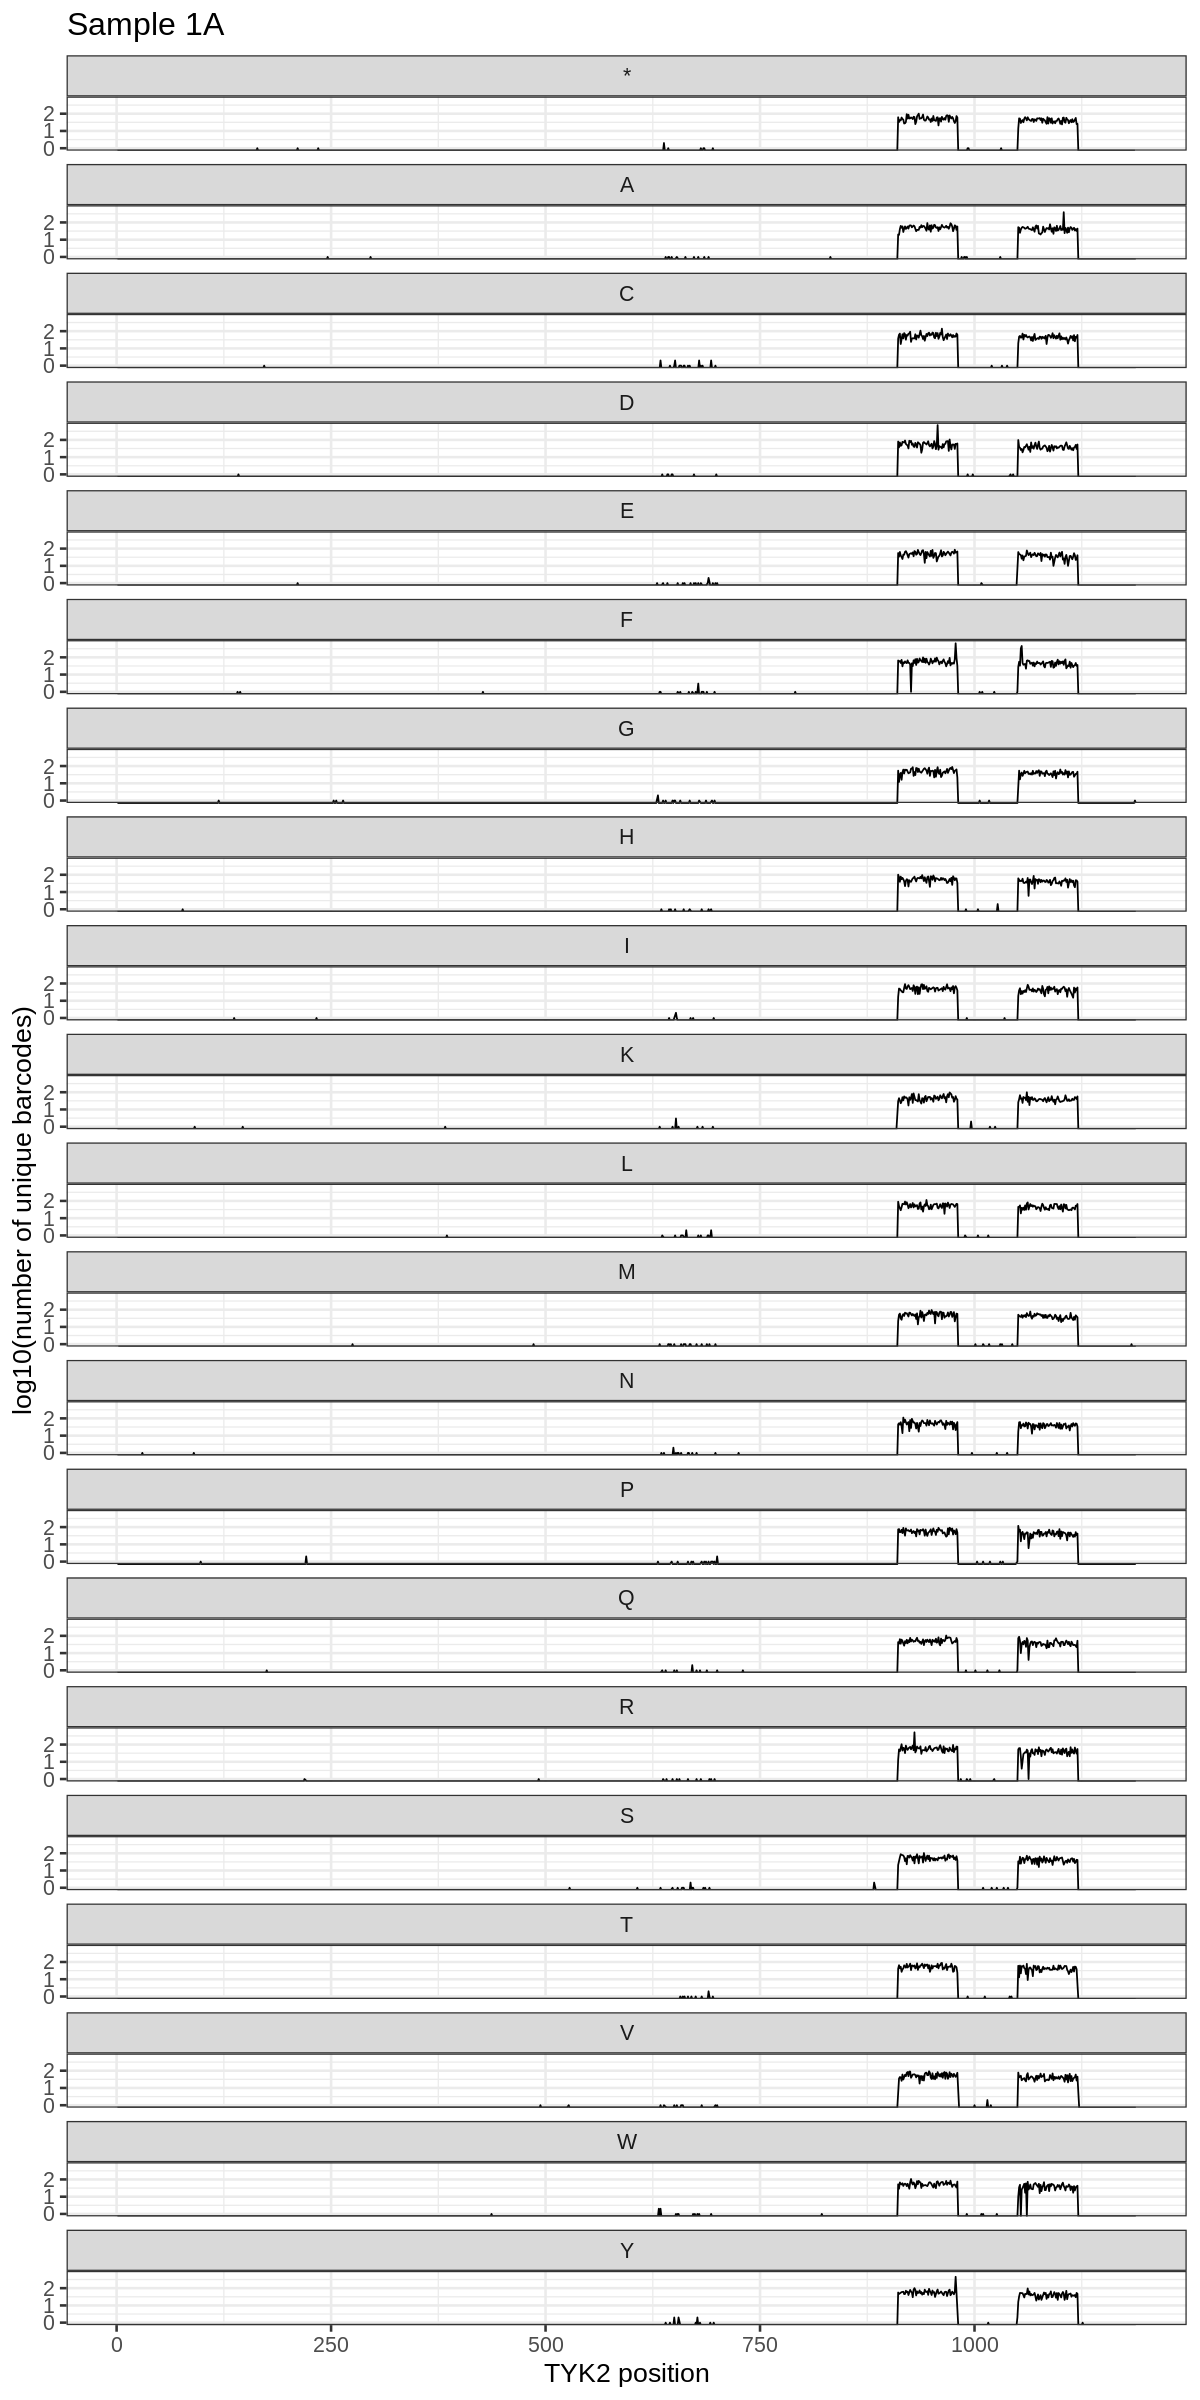

In [14]:
options(repr.plot.width = 10, repr.plot.height = 20)
coverage_plots[[1]]

### Inference and Stop Codon Effects <a name="part2"></a>

In [3]:
sumstats <- dir_ls(path = "../sumstats/TYK2/run6/", regexp = "tyk2_.*-combined.sumstats.tsv") %>%
    map_dfr(read_tsv, col_types = c("ncccnnnnnc")) %>%
    filter(grepl("aa",term), pos != 1188) %>%
    separate(term, c("condition", "aa"), ":") %>%
    mutate(estimate = estimate / log(2),
           std.error = std.error / log(2),
           condition = gsub("condition", "", condition),
           group = if_else(aa %in% c("mut_aa*", "mut_aaX"), chunk, "Non-Stop"),
           aa = gsub("mut_aa", "", aa),
           aa = if_else(aa %in% c("*","X"), "*", aa))

wt_aa <- read_tsv("../data/tyk2/tyk2-wt-aa.tsv")

Rows: 1189 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): wt_aa
dbl (1): pos

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [4]:
# sumstats %>%
#     mutate(p.adj = p.adjust(p.value, method = "BH")) %>%
#     select(-group) %>%
#     write_tsv("../sumstats/TYK2/run3/tyk2-assay3-unnormalized.tsv")

aa_uniq <- unique(sumstats$aa)
pos_uniq <- 1:1187

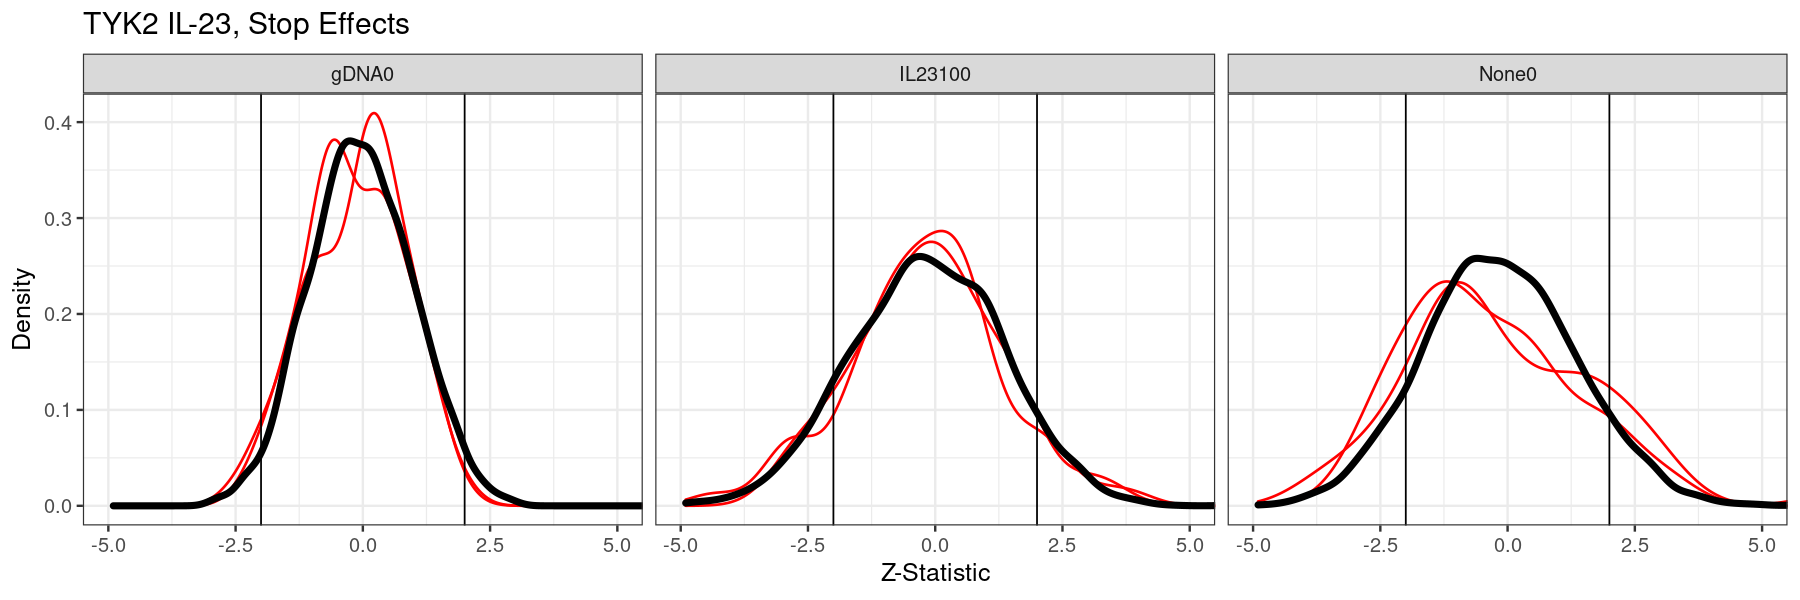

In [66]:
options(repr.plot.width = 15, repr.plot.height = 5)
sumstats %>%
    mutate(group = if_else(aa == "*", chunk, "Non-Stop")) %>%
    ggplot() +
        geom_density(aes(x = statistic, group = group,
                         color = group != "Non-Stop",
                         size = group != "Non-Stop"), alpha = 0.5) +
        facet_wrap(~condition, ncol = 3) +
        theme_bw(base_size = 15) +
        scale_color_manual(values = c("FALSE" = "black", "TRUE" = "red")) +
        scale_size_manual(values = c("FALSE" = 2, "TRUE" = 0.75)) +
        theme(legend.pos = "none") +
        xlab("Z-Statistic") + ylab("Density") +
        ggtitle("TYK2 IL-23, Stop Effects") +
        coord_cartesian(xlim = c(-5,5)) +
        geom_vline(xintercept = c(-2,2))

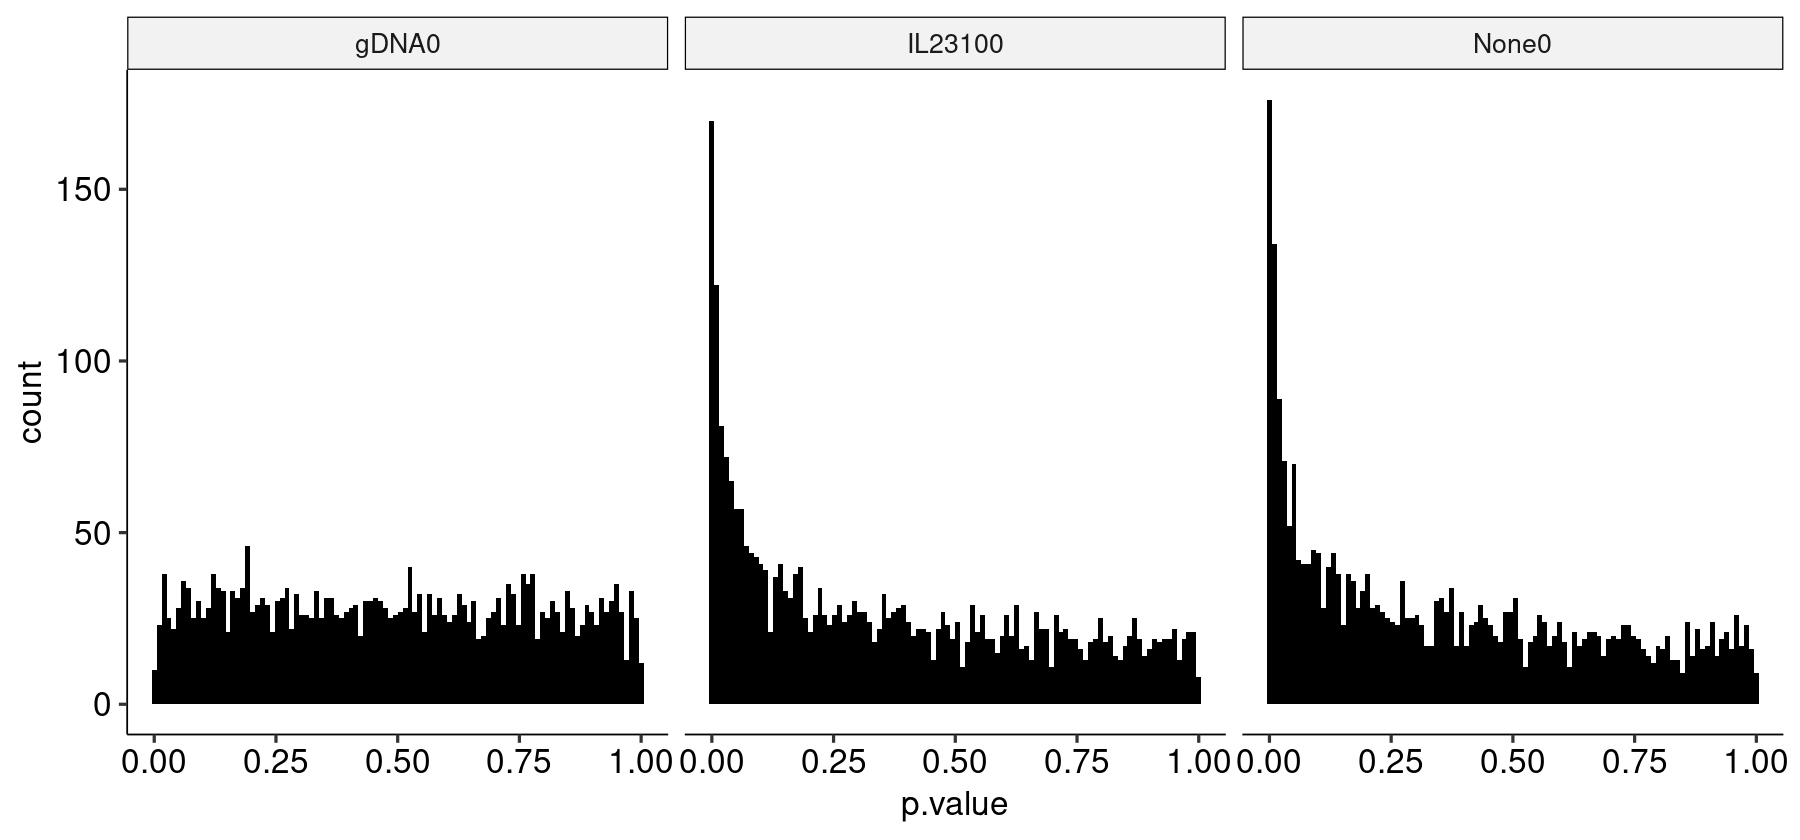

In [121]:
sumstats %>%
    ggplot() +
        geom_histogram(aes(x = p.value), bins = 100, color = NA, fill = "black") +
        theme_pubr(base_size = 20) +
        facet_wrap(~condition, nrow = 1)

In [77]:
sumstats %>%
    mutate(p.adj = p.adjust(p.value, method = "fdr")) %>%
    filter(p.adj < 0.01) %>%
    select(pos, condition, aa, estimate, std.error, statistic, p.value, p.adj) %>%
    arrange(pos)

pos,condition,aa,estimate,std.error,statistic,p.value,p.adj
<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
911,IL23100,*,-0.6933807,0.1586946,-4.369278,1.246582e-05,5.813229e-03
916,IL23100,C,-0.6552358,0.1522913,-4.302517,1.688685e-05,6.763842e-03
926,None0,Y,0.7069348,0.1652121,4.278952,1.877749e-05,6.852969e-03
935,None0,V,0.9636704,0.1986476,4.851156,1.227438e-06,1.470740e-03
936,None0,Y,1.0091754,0.1776301,5.681332,1.336499e-08,3.739524e-05
945,IL23100,F,-0.7889376,0.1643836,-4.799369,1.591665e-06,1.484493e-03
954,IL23100,C,-0.8393561,0.1981266,-4.236463,2.270683e-05,7.941713e-03
954,IL23100,W,-0.8075816,0.1839288,-4.390728,1.129716e-05,5.578141e-03
955,None0,F,0.9665538,0.1979005,4.884039,1.039343e-06,1.470740e-03


### Visualizations <a name="part3"></a>

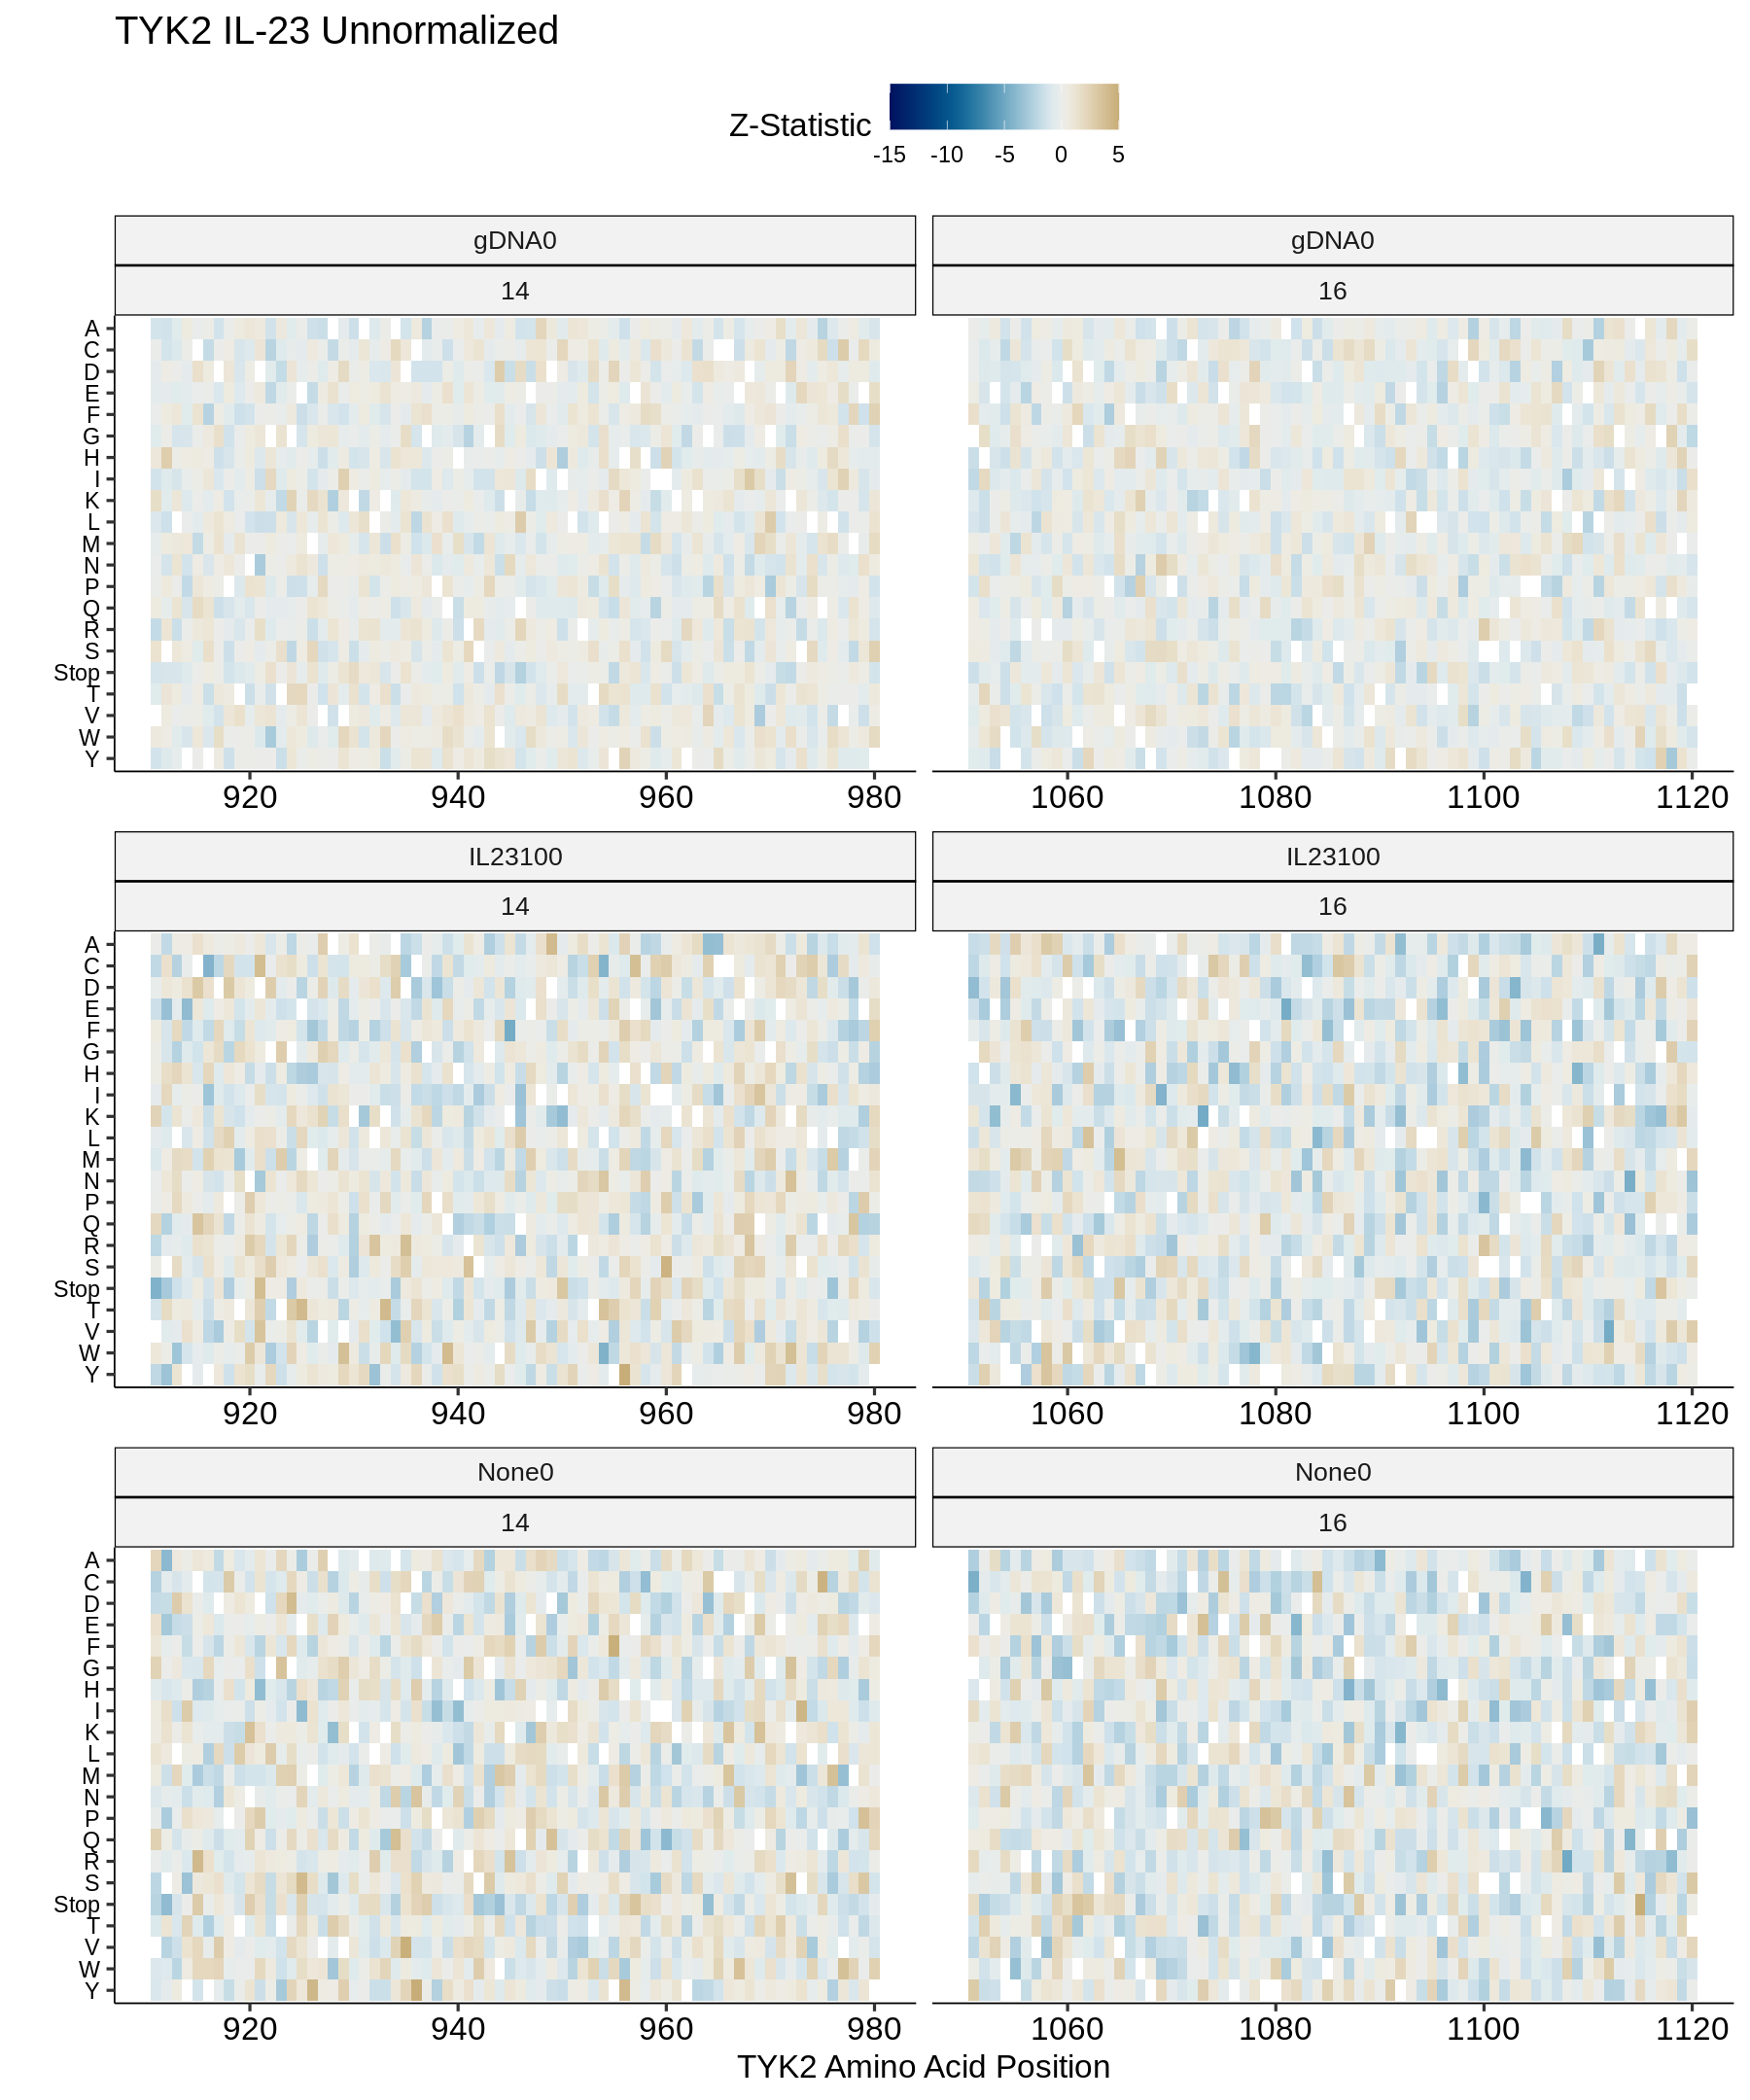

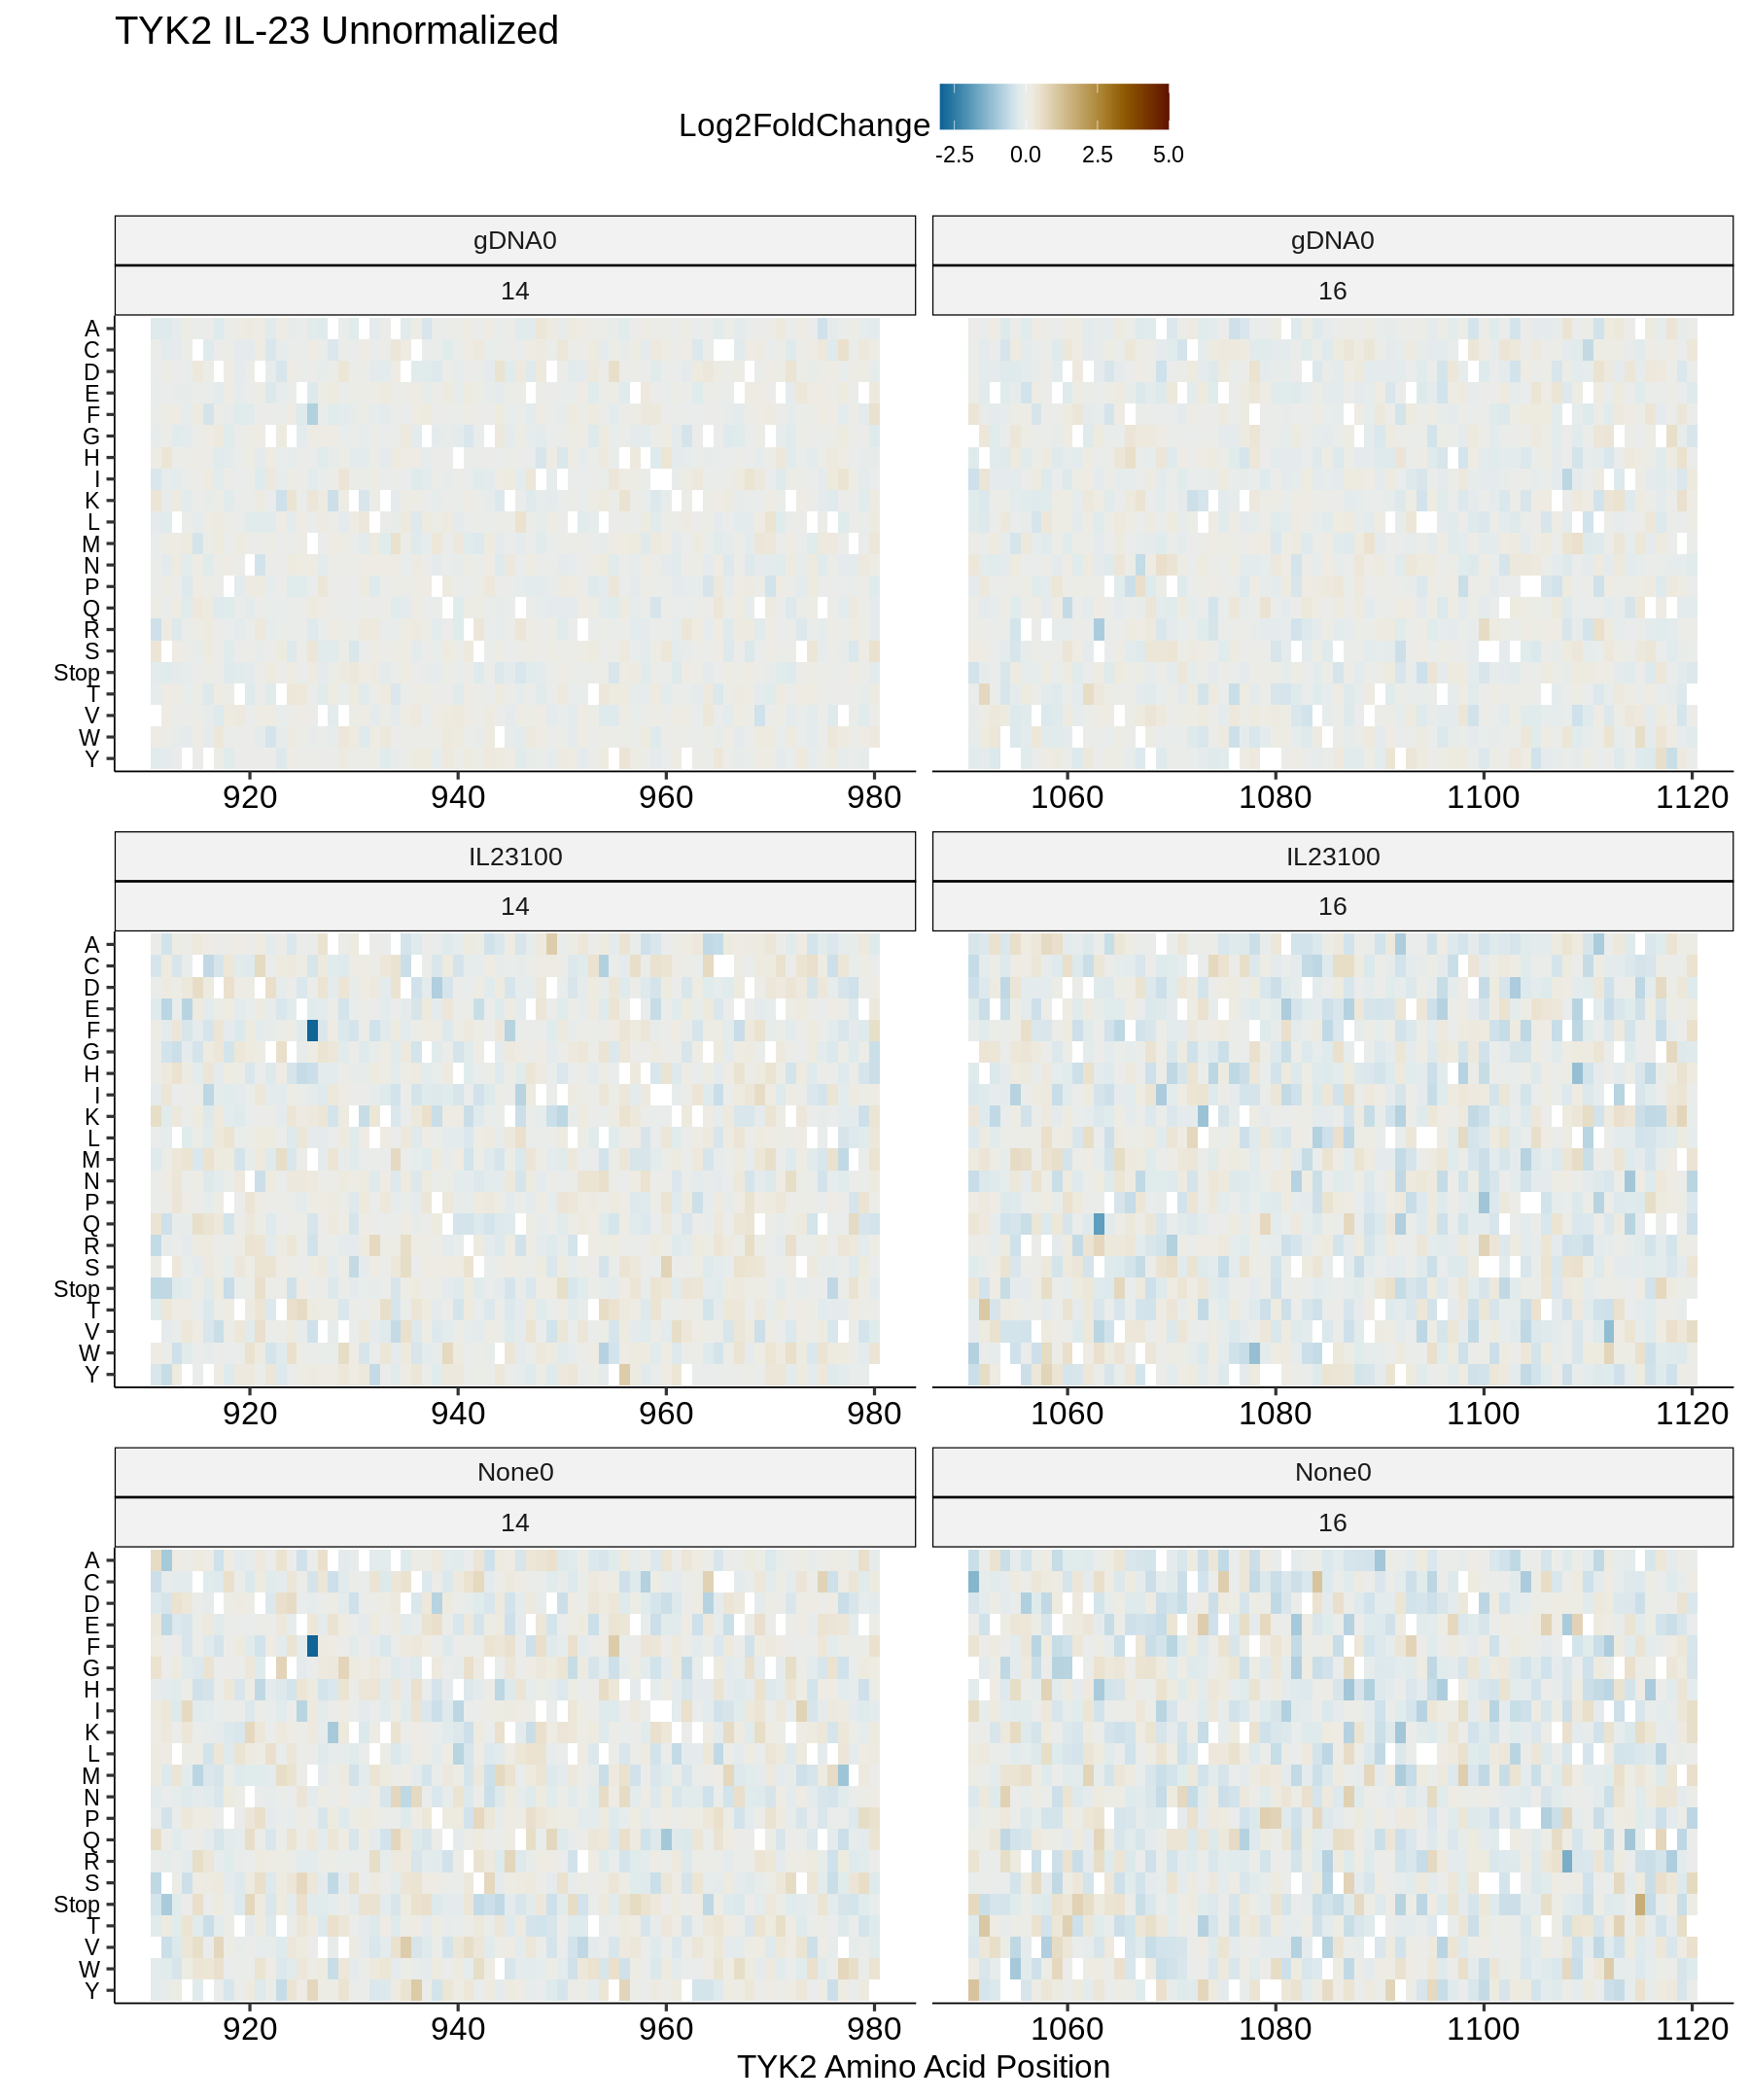

In [11]:
options(repr.plot.width = 15, repr.plot.height = 18)
heatmap_z <- sumstats %>%
    mutate(aa = gsub("mut_aa", "", aa),
           aa = if_else(aa %in% c("*", "X"), "Stop", aa)) %>%
    rename("Z-Statistic" = "statistic") %>%
    ggplot() +
            geom_tile(aes(x = pos, y = fct_rev(aa), fill =`Z-Statistic`)) +
            scale_fill_scico_mid( limits = c(-15,5), palette = "vik", mid = 0, oob = squish) +
            theme_pubr(base_size = 20) +
            theme(legend.text=element_text(size=14),
                  legend.key.size = unit(1,"cm"),
                  axis.text.y = element_text(size = 14)) +
            ylab("") + xlab("TYK2 Amino Acid Position") +
            facet_wrap(~condition + chunk, ncol = 2, scales = "free_x") +
            ggtitle("TYK2 IL-23 Unnormalized")

heatmap_l2fc <- sumstats %>%
    mutate(aa = gsub("mut_aa", "", aa),
           aa = if_else(aa %in% c("*", "X"), "Stop", aa)) %>%
    rename("Log2FoldChange" = "estimate") %>%
    ggplot() +
            geom_tile(aes(x = pos, y = fct_rev(aa), fill = Log2FoldChange)) +
            scale_fill_scico_mid( limits = c(-3,5), palette = "vik", mid = 0, oob = squish) +
            theme_pubr(base_size = 20) +
            theme(legend.text=element_text(size=14),
                  legend.key.size = unit(1,"cm"),
                  axis.text.y = element_text(size = 14)) +
            ylab("") + xlab("TYK2 Amino Acid Position") +
            facet_wrap(~condition + chunk, ncol = 2, scales = "free_x") +
            ggtitle("TYK2 IL-23 Unnormalized")

heatmap_z
heatmap_l2fc

In [13]:
ggsave("../dataviz/TYK2/il23/TYK2-IL23-L2FC.pdf",
      heatmap_l2fc, width = 15, height = 18)
ggsave("../dataviz/TYK2/il23/TYK2-IL23-Z.pdf",
      heatmap_z, width = 15, height = 18)

In [113]:
mapped_counts_assay3_p1104ax <- vroom("../pipeline/OCNT-DMSLIB-1-assay-run3/combined/P1104AX.tsv",
                          col_names = c("sample", "barcode", "lib", "chunk",
                                        "wt_aa", "pos", "mut_aa", "wt_codon", "mut_codon",
                                        "dox", "condition", "condition_conc","clone", "count"))

p1104a_x <- mapped_counts %>% filter(pos == 1104, mut_aa %in% c("A","*"))

Rows: 3509 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (9): sample, barcode, lib, wt_aa, mut_aa, wt_codon, mut_codon, dox, cond...
dbl (5): chunk, pos, condition_conc, clone, count

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


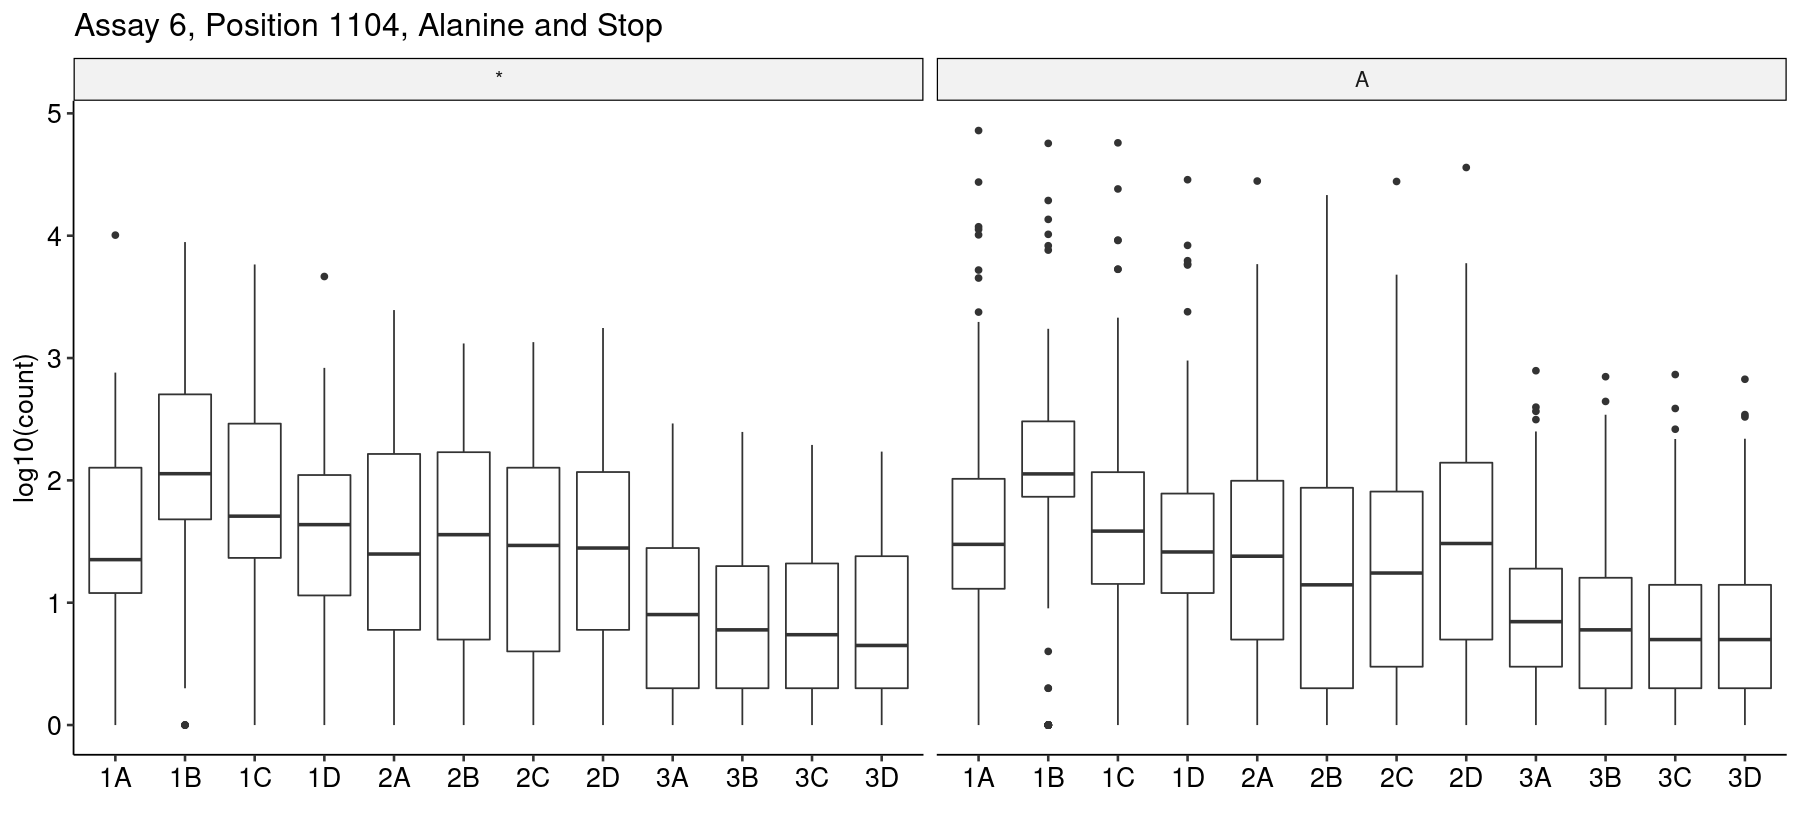

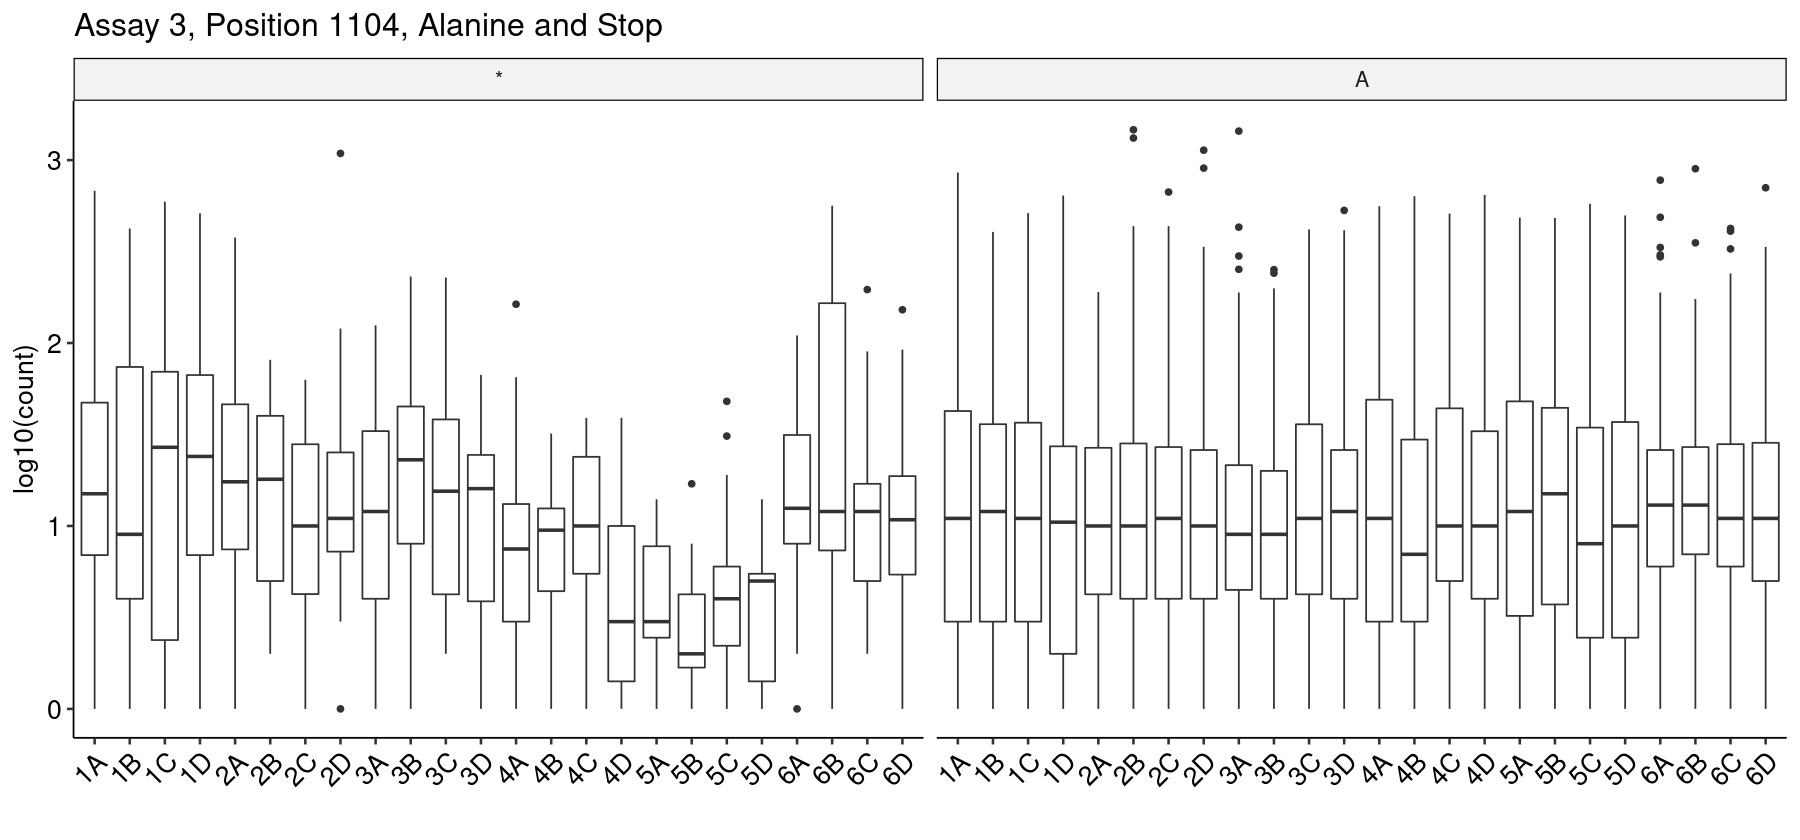

In [120]:
options(repr.plot.width = 15, repr.plot.height = 7)

ggplot(p1104a_x) +
    geom_boxplot(aes(x = sample, y = log10(count))) +
    facet_wrap(~mut_aa)  +
    theme_pubr(base_size = 16) + 
    ggtitle("Assay 6, Position 1104, Alanine and Stop") +
    xlab("")

ggplot(mapped_counts_assay3_p1104ax) +
    geom_boxplot(aes(x = sample, y = log10(count))) +
    facet_wrap(~mut_aa) +
    theme_pubr(base_size = 16, x.text.angle = 45)  + 
    ggtitle("Assay 3, Position 1104, Alanine and Stop") +
    xlab("")


### Raw Data Review <a name="part4"></a>

These data look very flat across conditions. To make sure we didn't miss anything computationally or statistically, we can examine the raw barcode count data of a few positions in very high resolution, and compare it to another dataset (here, run 3). Since it is a spike-in shared by both datasets, we choose position *930R* and compare it to WT for its segment (chunk 14). Let's just look at the raw counts:

In [4]:
mapped_counts <- vroom("../pipeline/OCNT-DMSLIB-1-assay-run6/tyk2-form.mapped-counts.tsv",
                          col_names = c("sample", "barcode", "count", "lib", "chunk",
                                        "wt_aa", "pos", "mut_aa", "wt_codon", "mut_codon", "chunkID",
                                        "dox", "condition", "condition_conc","clone")) %>%
    mutate(mut_aa = if_else(mut_aa %in% c("*", "X"), "*", mut_aa),
           condition = as.factor(paste0(condition, condition_conc)),
           mut_aa = if_else(wt_aa == mut_aa | is.na(mut_aa), "WT", mut_aa),
           mut_aa = relevel(as.factor(mut_aa), ref = "WT")) %>%
    group_by(sample) %>%
    mutate(mean_count = mean(log(count)),
           stop_count = sum(count[which(mut_aa == "*")]),
           total_count = log(sum(count)))

mapped_counts_compare <- vroom("../pipeline/OCNT-DMSLIB-1-assay-run3/combined/tyk2-form-14.mapped-counts.tsv",
                          col_names = c("sample", "barcode", "lib", "chunk",
                                        "wt_aa", "pos", "mut_aa", "wt_codon", "mut_codon",
                                        "dox", "condition", "condition_conc","clone", "count")) %>%
    mutate(mut_aa = if_else(mut_aa %in% c("*", "X"), "*", mut_aa),
           condition = as.factor(paste0(condition, condition_conc)),
           mut_aa = if_else(wt_aa == mut_aa | is.na(mut_aa), "WT", mut_aa),
           mut_aa = relevel(as.factor(mut_aa), ref = "WT")) %>%
    group_by(sample) %>%
    mutate(mean_count = mean(log(count)),
           stop_count = sum(count[which(mut_aa == "*")]),
           total_count = log(sum(count)))

Rows: 2510594 Columns: 15
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (10): sample, barcode, lib, wt_aa, mut_aa, wt_codon, mut_codon, chunkID,...
dbl  (5): count, chunk, pos, dox, condition_conc

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1376771 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (9): sample, barcode, lib, wt_aa, mut_aa, wt_codon, mut_codon, dox, cond...
dbl (5): chunk, pos, condition_conc, clone, count

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


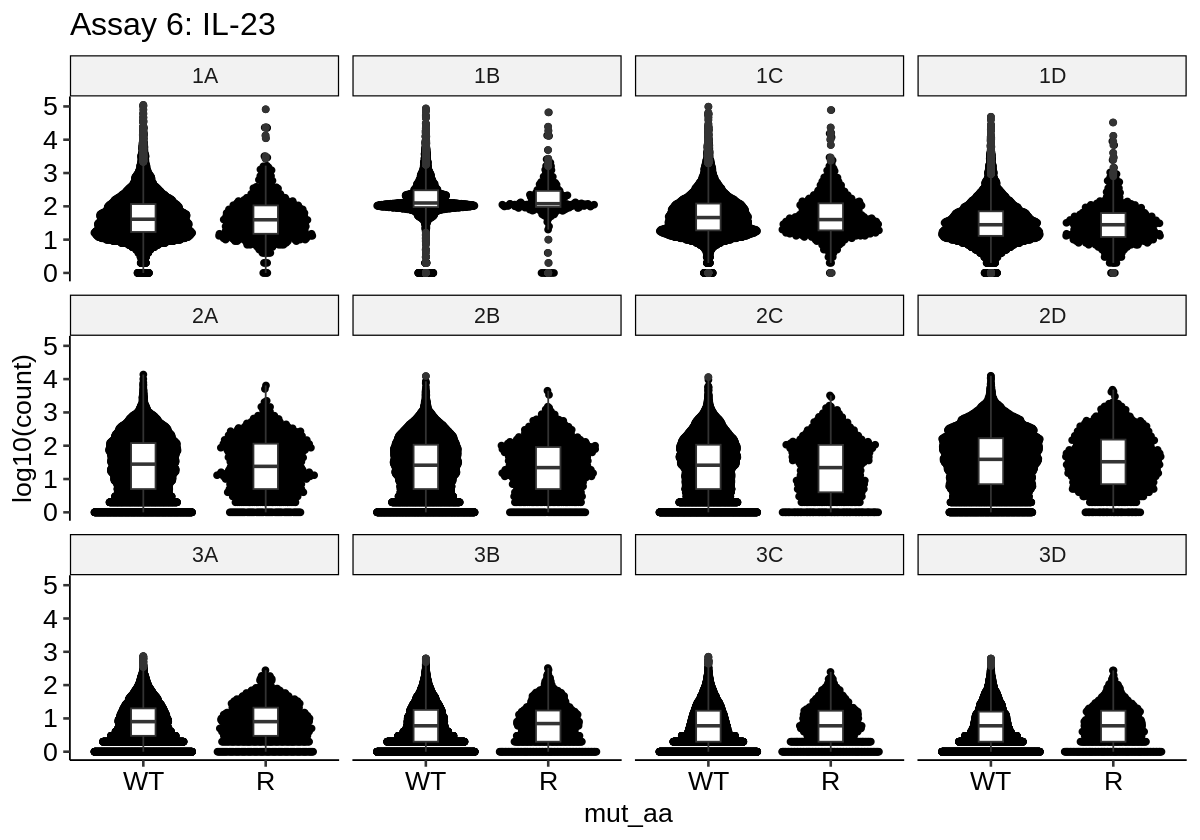

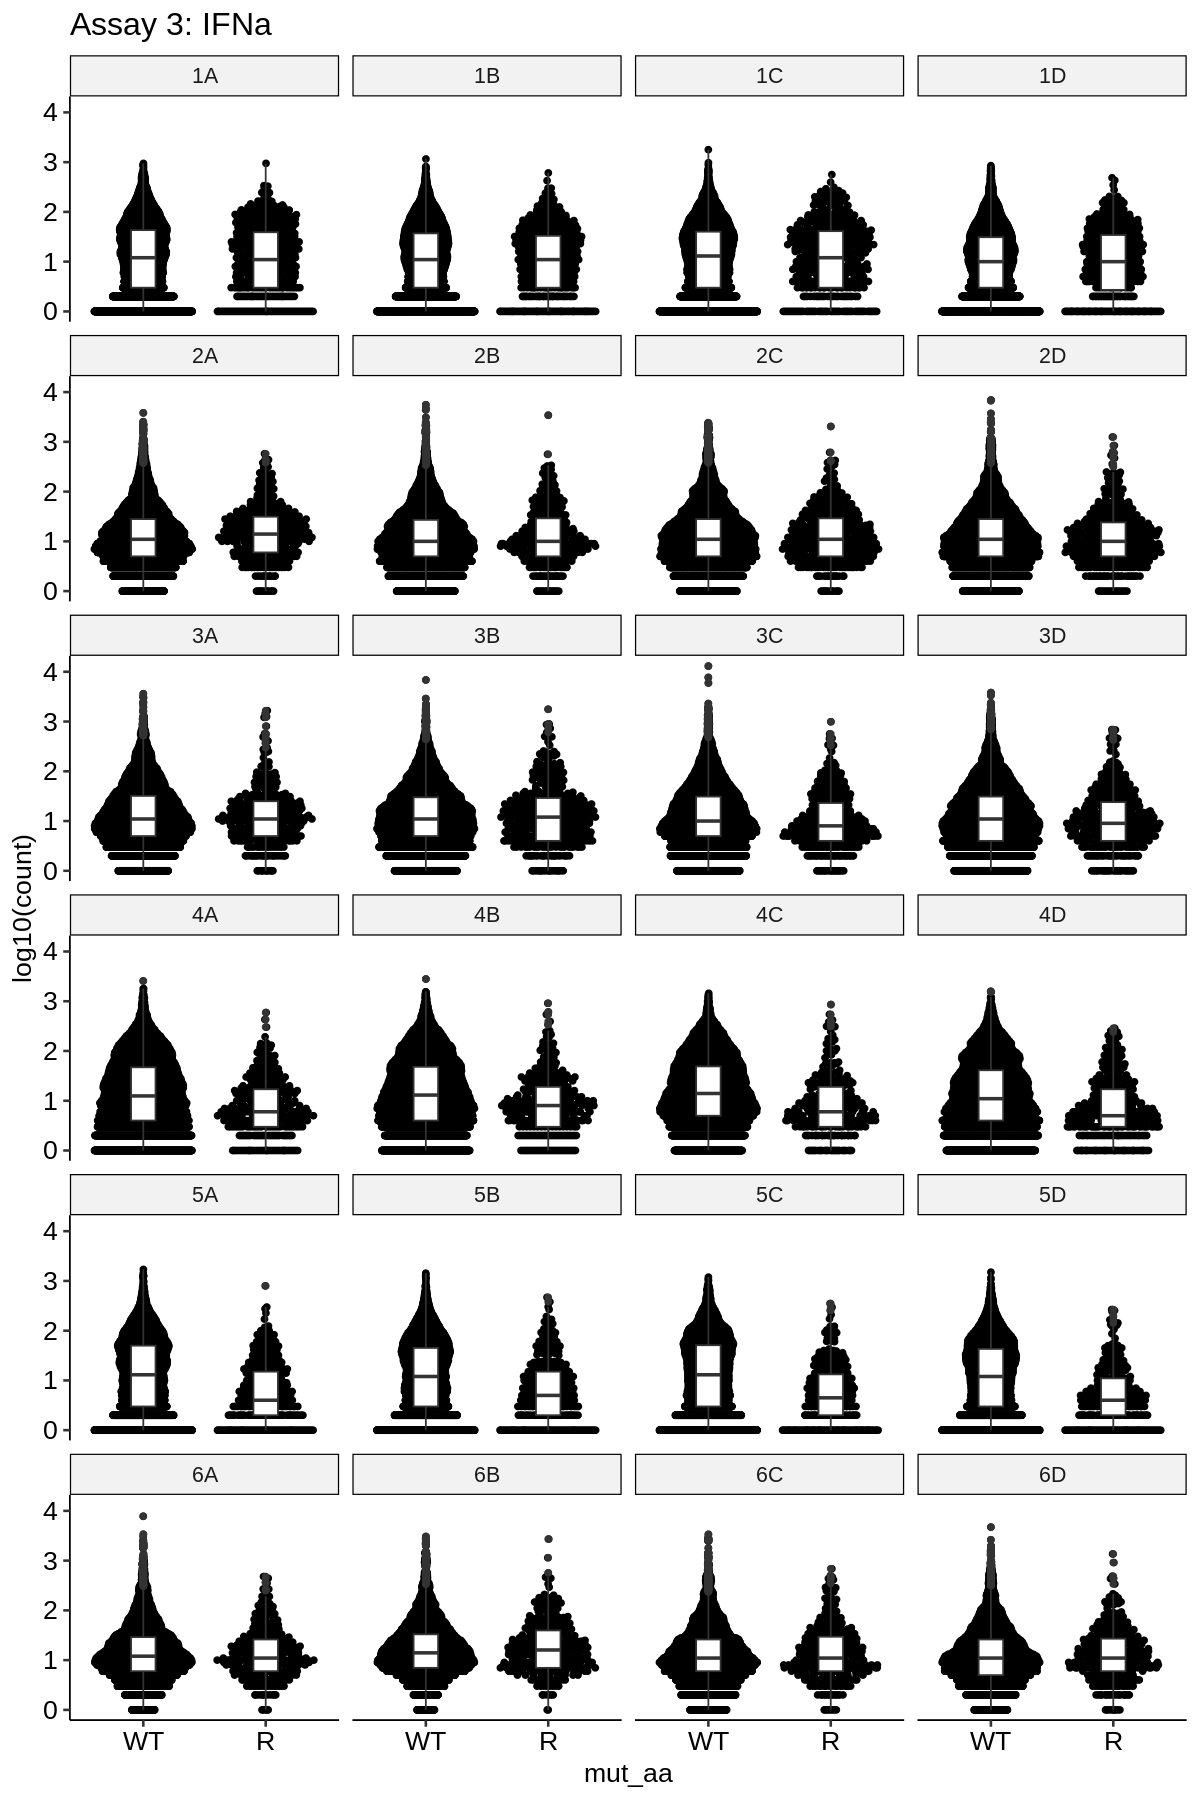

In [26]:
example_run6 <- mapped_counts %>%
    filter((pos == 930 & mut_aa == "R")|(chunk == 14 & mut_aa == "WT")) 

example_run3 <- mapped_counts_compare %>%
    filter((pos == 930 & mut_aa == "R")|(chunk == 14 & mut_aa == "WT")) 

options(repr.plot.width = 10, repr.plot.height = 7)
ggplot(example_run6) +
    geom_quasirandom(aes(x = mut_aa, y = log10(count))) +
    geom_boxplot(aes(x = mut_aa, y = log10(count)), width = 0.2) +
    facet_wrap(~sample, ncol = 4) +
    ggtitle("Assay 6: IL-23") +
    theme_pubr(base_size = 16)

options(repr.plot.width = 10, repr.plot.height = 15)
ggplot(example_run3) +
    geom_quasirandom(aes(x = mut_aa, y = log10(count))) +
    geom_boxplot(aes(x = mut_aa, y = log10(count)), width = 0.2) +
    facet_wrap(~sample, ncol = 4) +
    ggtitle("Assay 3: IFNa")  +
    theme_pubr(base_size = 16)

To compare these distributions, we extract and plot the empirical cumulative density, which shows the varint effect size growing more negative with increasing IFNa concentration (but with no effect change in IL-23):

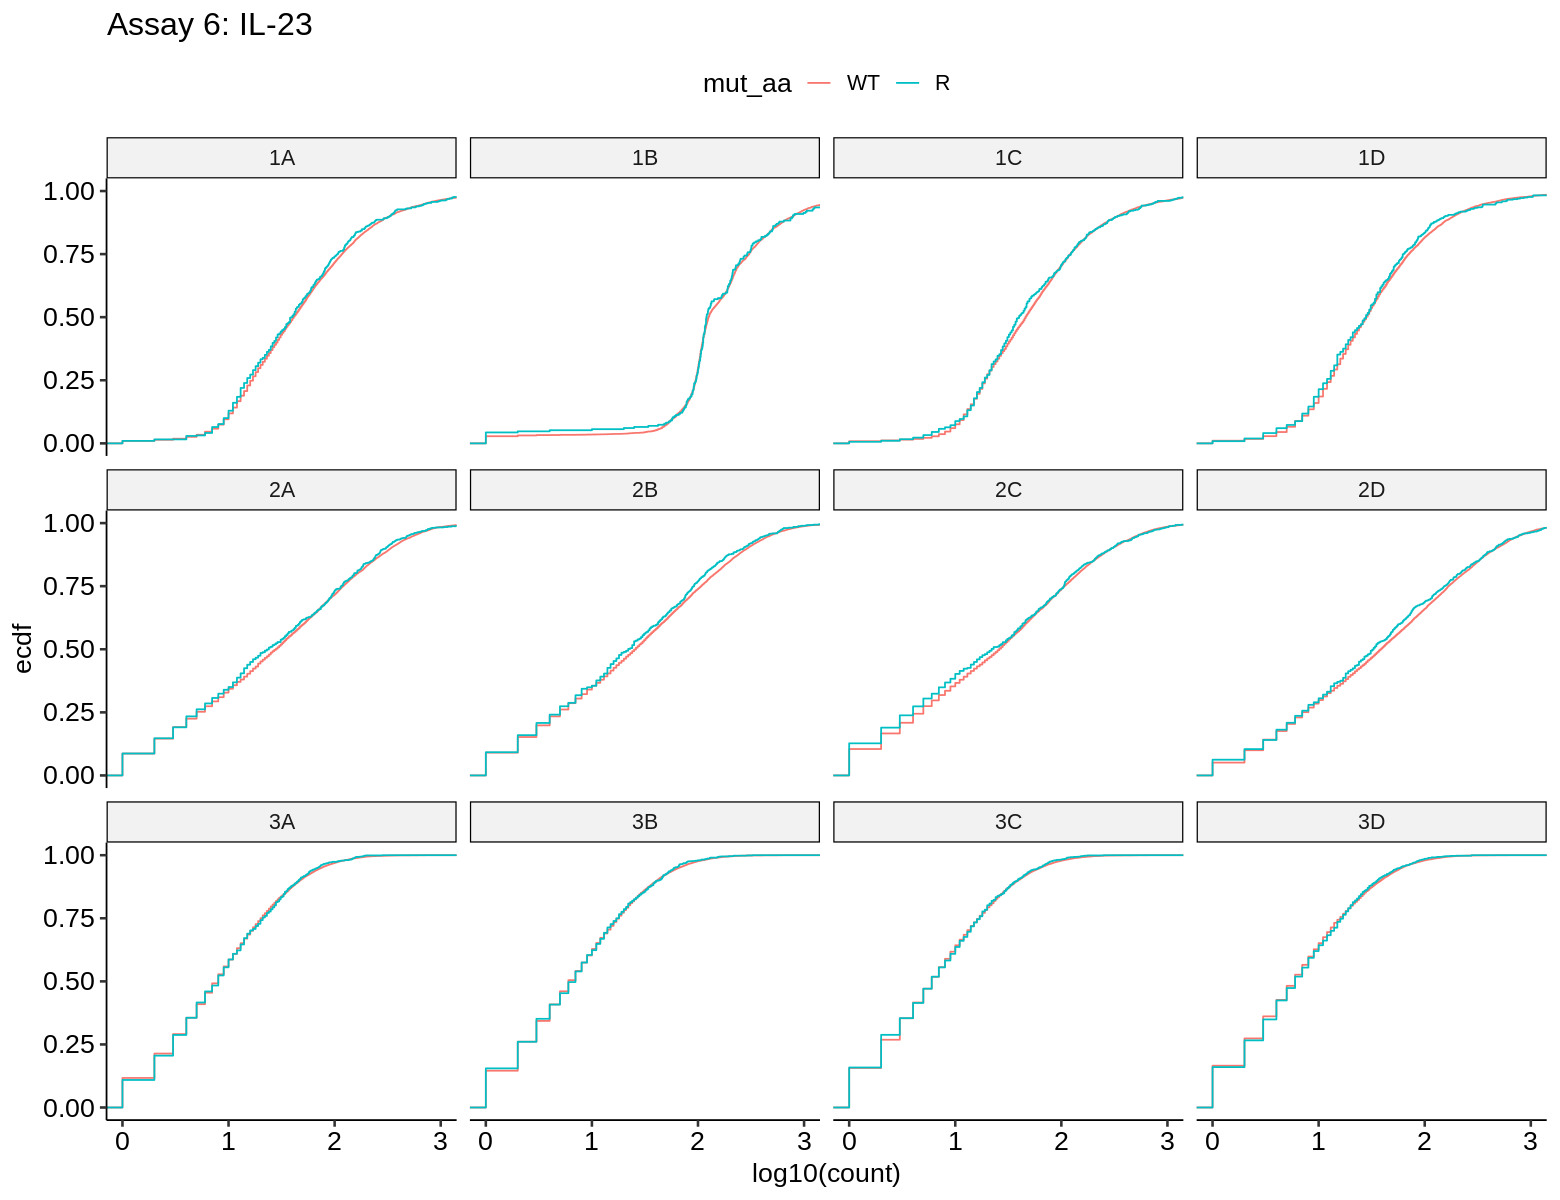

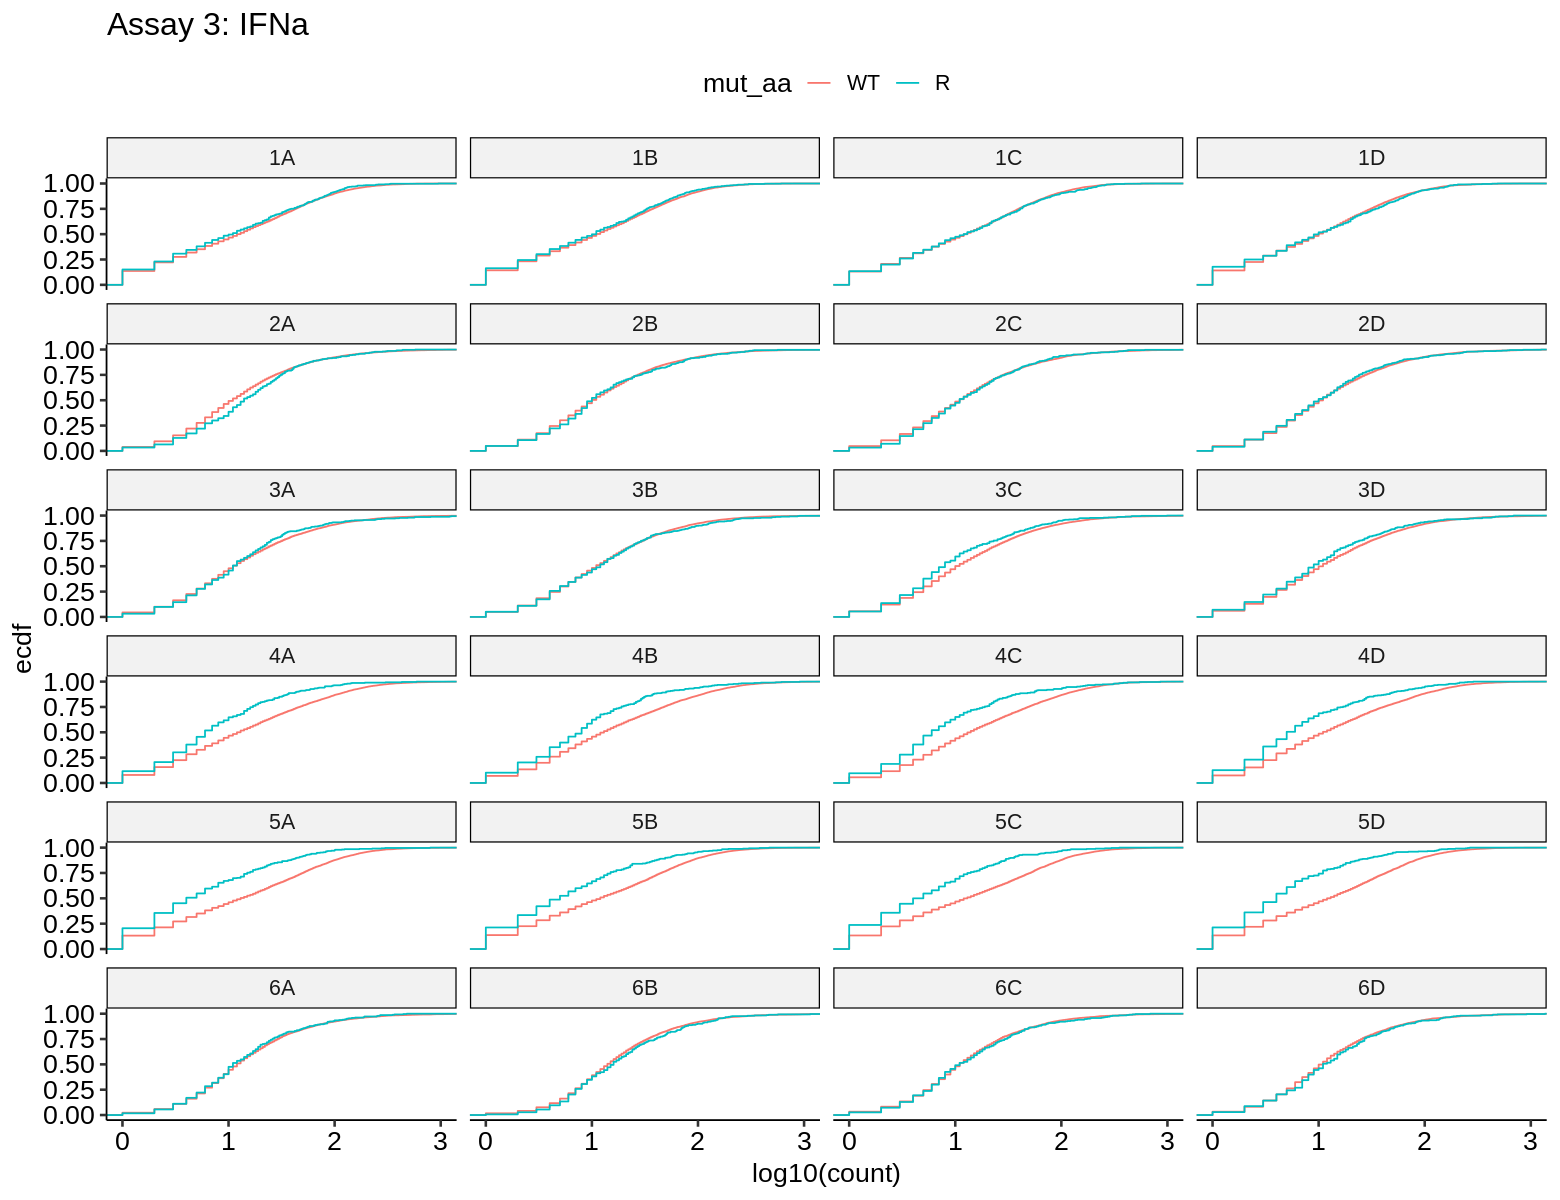

In [27]:
options(repr.plot.width = 13, repr.plot.height = 10)
example_run6 %>%
    ggplot() +
        stat_ecdf(aes(x = log10(count), color = mut_aa)) +
        facet_wrap(~sample, ncol = 4) +
        theme_pubr(base_size = 16) +
        ggtitle("Assay 6: IL-23") +
        coord_cartesian(xlim = c(0,3))

example_run3 %>%
    ggplot() +
        stat_ecdf(aes(x = log10(count), color = mut_aa)) +
        facet_wrap(~sample, ncol = 4) +
        theme_pubr(base_size = 16) +
        ggtitle("Assay 3: IFNa") +
        coord_cartesian(xlim = c(0,3))

This is pretty clear, but we can get more precise. Since we have the barcode sequences associated with each count, we can subset each dataset to only include the barcodes which are detected in the _other_ dataset at least once.

In [28]:
whitelist <- intersect(str_c(example_run6$barcode, example_run6$mut_aa),
                       str_c(example_run3$barcode, example_run3$mut_aa))


In [34]:
bind_rows(example_run6 %>% ungroup() %>% select(barcode) %>% distinct(),
          example_run3 %>% ungroup() %>% select(barcode) %>% distinct()) %>% 
    count(barcode) %>%
    count(n, name = "nn") %>%
    mutate(n = case_when(n == 1 ~ "One Assay",
                         n == 2 ~ "Both Assays")) %>%
    rename("group" = "n", "number of barcodes" = "nn") %>%
    kable("markdown")



|group       | number of barcodes|
|:-----------|------------------:|
|One Assay   |              35713|
|Both Assays |               7492|

Most barcodes are only detected in one assay, but 7492 barcodes are detected in both (though presumably not in all samples). We can subset to just these barcodes, and plot the same data views:

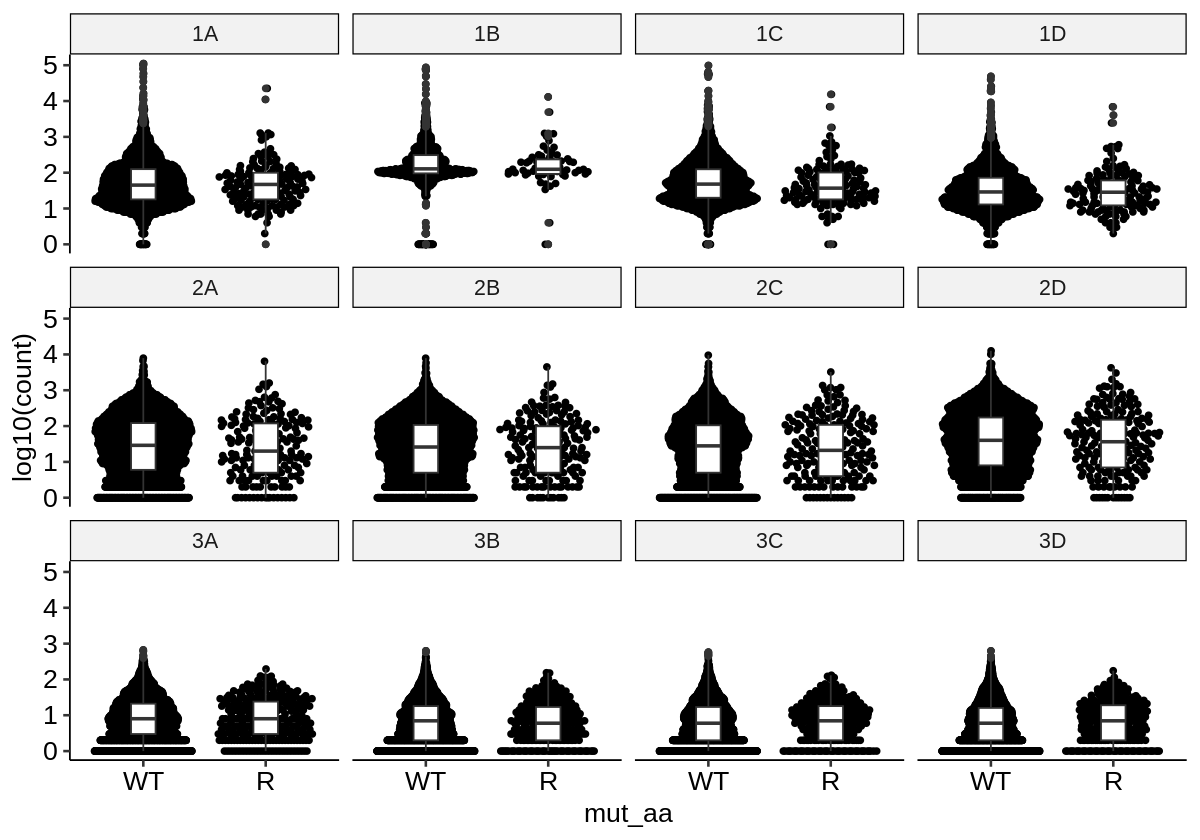

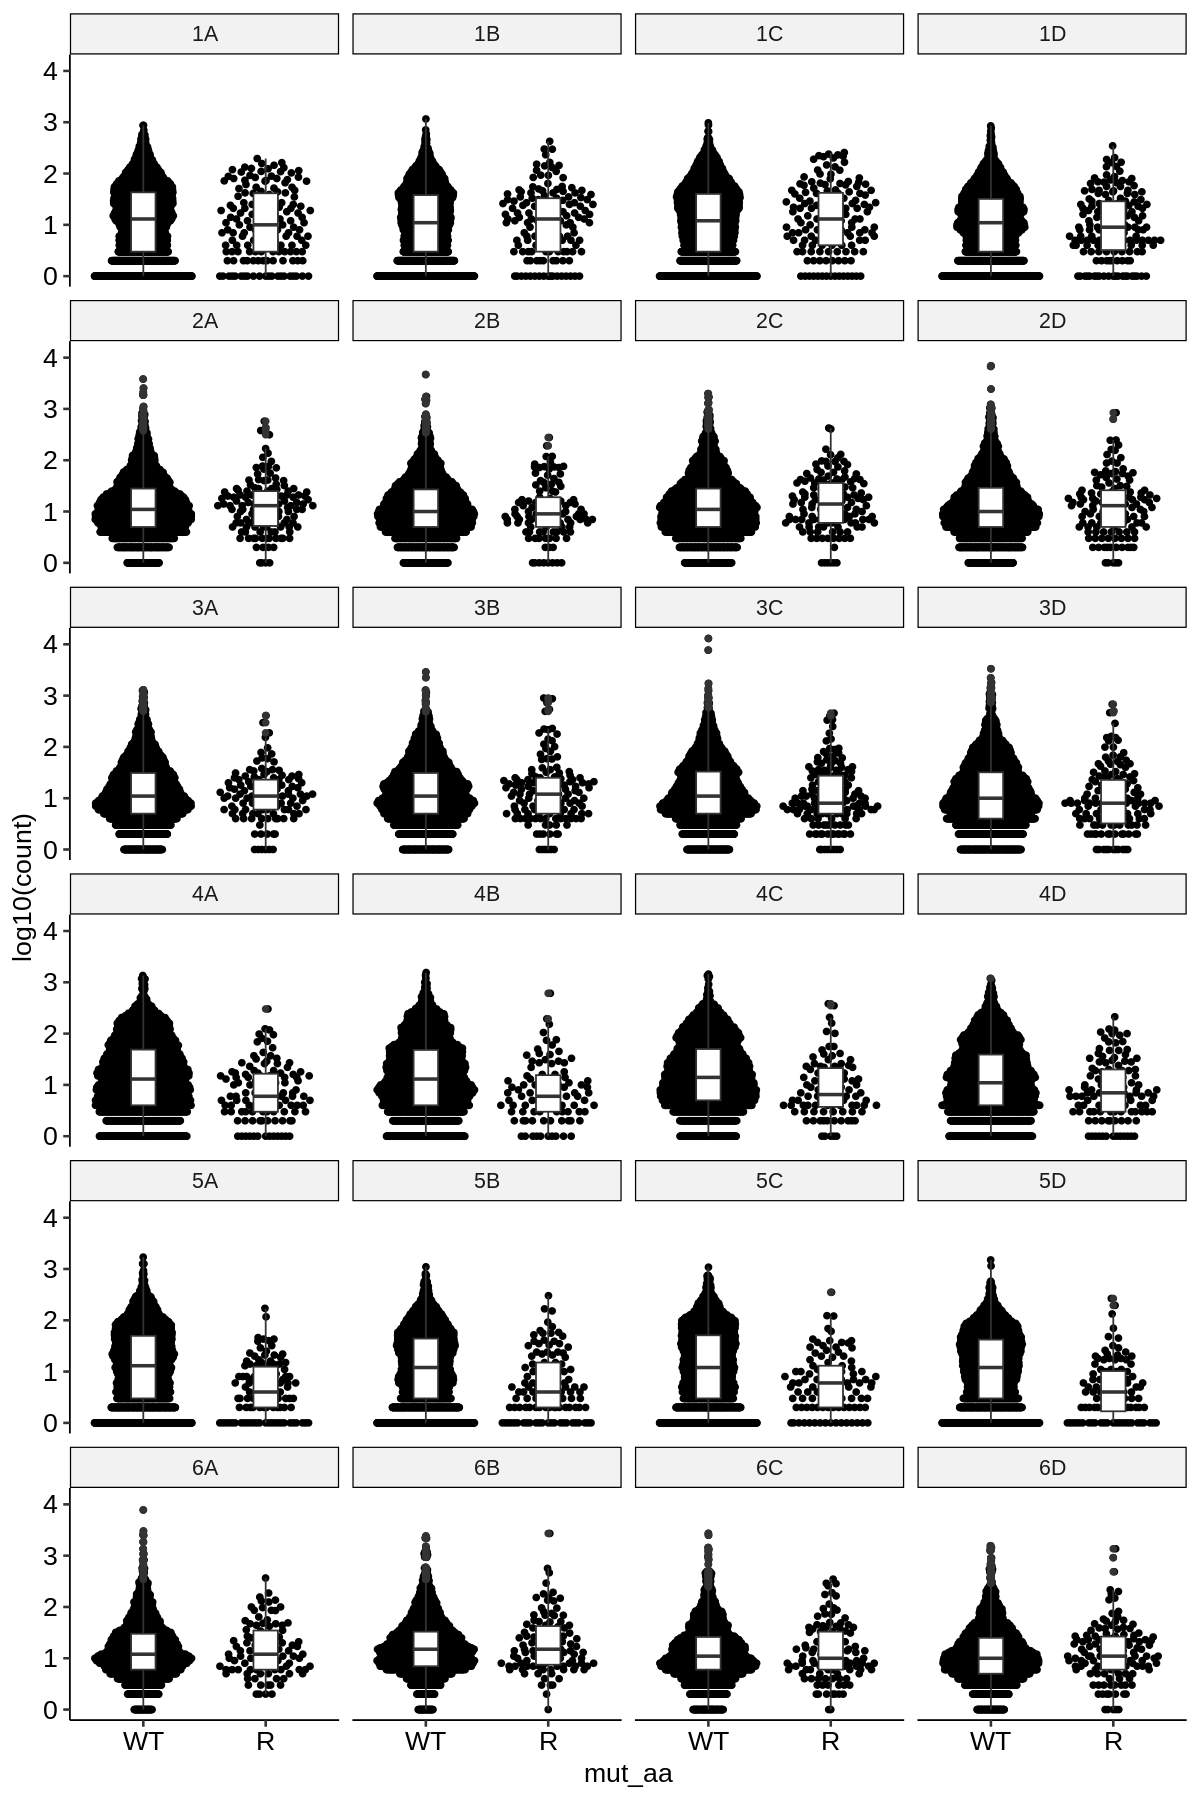

In [31]:
options(repr.plot.width = 10, repr.plot.height = 7)
example_run6 %>%
    filter(str_c(barcode, mut_aa) %in% whitelist) %>%
    ggplot() +
        geom_quasirandom(aes(x = mut_aa, y = log10(count))) +
        geom_boxplot(aes(x = mut_aa, y = log10(count)), width = 0.2) +
        facet_wrap(~sample, ncol = 4) +
        theme_pubr(base_size = 16)

options(repr.plot.width = 10, repr.plot.height = 15)
example_run3 %>%
    filter(str_c(barcode, mut_aa) %in% whitelist) %>%
    ggplot() +
        geom_quasirandom(aes(x = mut_aa, y = log10(count))) +
        geom_boxplot(aes(x = mut_aa, y = log10(count)), width = 0.2) +
        facet_wrap(~sample, ncol = 4) +
        theme_pubr(base_size = 16)

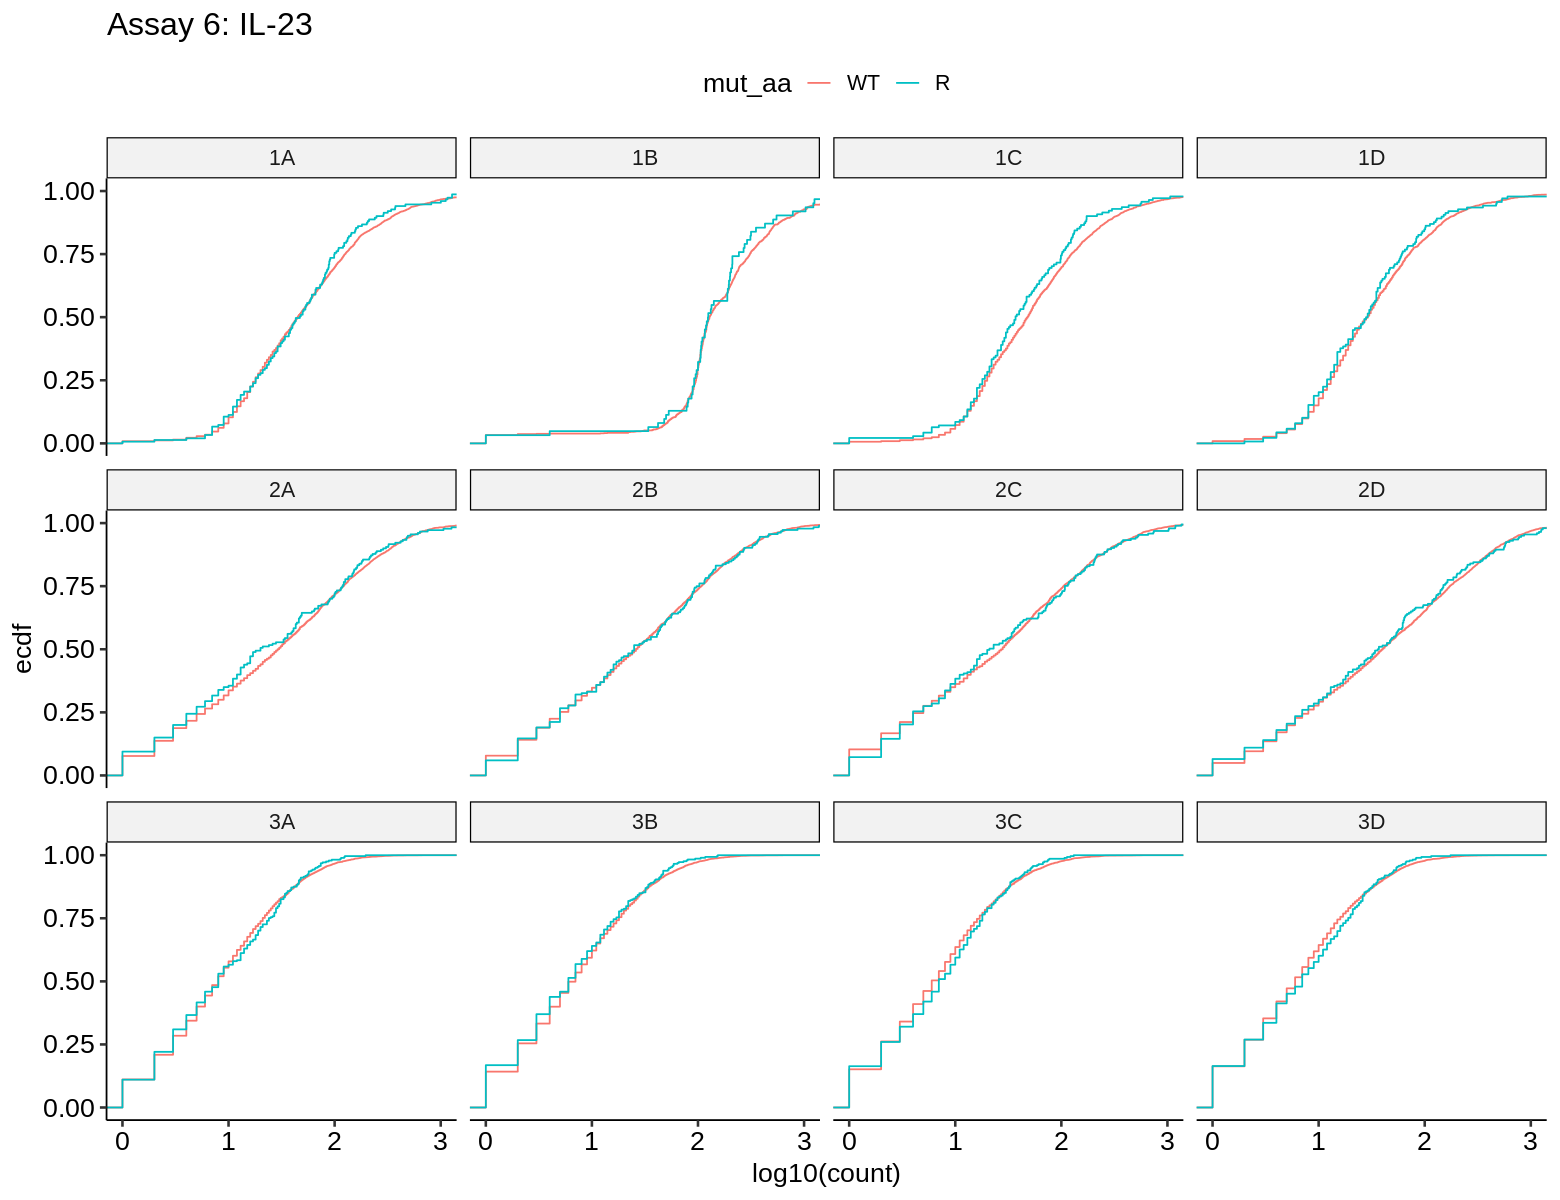

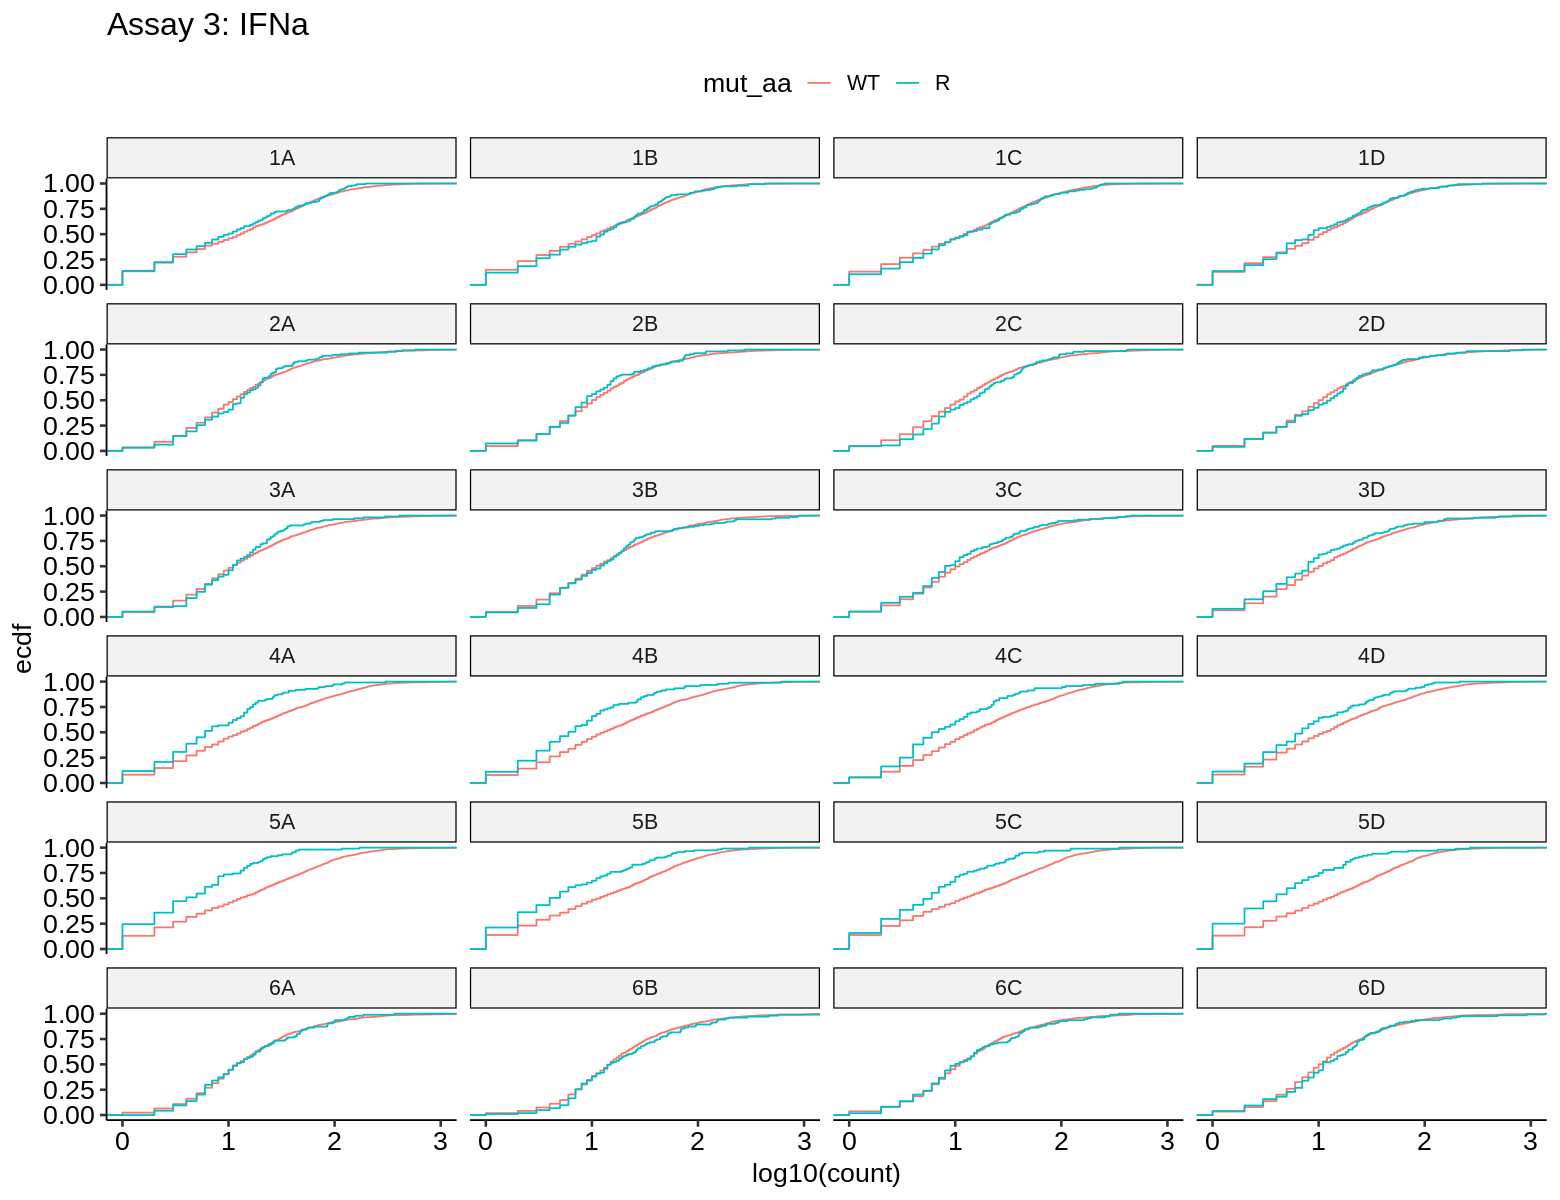

In [33]:
options(repr.plot.width = 13, repr.plot.height = 10)
example_run6 %>%
    filter(str_c(barcode, mut_aa) %in% whitelist) %>%
    ggplot() +
        stat_ecdf(aes(x = log10(count), color = mut_aa)) +
        facet_wrap(~sample, ncol = 4) +
        theme_pubr(base_size = 16) +
        ggtitle("Assay 6: IL-23") +
        coord_cartesian(xlim = c(0,3))

example_run3 %>%
    filter(str_c(barcode, mut_aa) %in% whitelist) %>%
    ggplot() +
        stat_ecdf(aes(x = log10(count), color = mut_aa)) +
        facet_wrap(~sample, ncol = 4) +
        theme_pubr(base_size = 16) +
        ggtitle("Assay 3: IFNa") +
        coord_cartesian(xlim = c(0,3))

So, even for these specific ~7500 barcodes, there is no different in raw counts within each sample in a way analogous to that observed in assay 3 with an IFN-alpha dose response.